### Imports

In [248]:
import pandas as pd
import pm4py

from abc import ABC, abstractmethod
from typing import List, Any, cast, Union
import json
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from IPython.display import display
from collections import defaultdict

### Data Loading and formatting

In [24]:
log_small_data = pm4py.format_dataframe(pd.read_csv("../data/flight_event_log.csv", sep=','), case_id='Flight', activity_key='Activity', timestamp_key='Timestamp')

log_medium_data = pm4py.format_dataframe(pd.read_csv("../data/p2p_event_log.csv", sep=','), case_id='Case ID', activity_key='ACTIVITY', timestamp_key='EVENTTIME')

log_big_data = pm4py.format_dataframe(pd.read_csv("../data/teleclaims.csv", sep=','), case_id='Case ID', activity_key='Activity', timestamp_key='Complete Timestamp')

BPI_data = pm4py.read_xes("../data/BPI_Challenge_2019.xes")

parsing log, completed traces :: 100%|██████████| 251734/251734 [00:24<00:00, 10246.62it/s]


### Silent transitions labelling

In [86]:
def enumerate_tau(node, counter):
    if (not hasattr(node, "children") or not node.children) and getattr(node, "label", None) is None:
        node.label = f"tau_{counter[0]}"
        counter[0] += 1

    if hasattr(node, "children") and node.children is not None:
        for child in node.children:
            enumerate_tau(child, counter)

none_counter = [1]

### Tree discovery

Function for TD with tau labelling and vizualization

In [145]:
def view_process_tree_lr(logs, p):
    tree = pm4py.discover_process_tree_inductive(logs, p)
    enumerate_tau(tree, none_counter)
    gviz = pt_visualizer.apply(tree)
    gviz.graph_attr['rankdir'] = 'TB'
    pt_visualizer.view(gviz)
    return tree

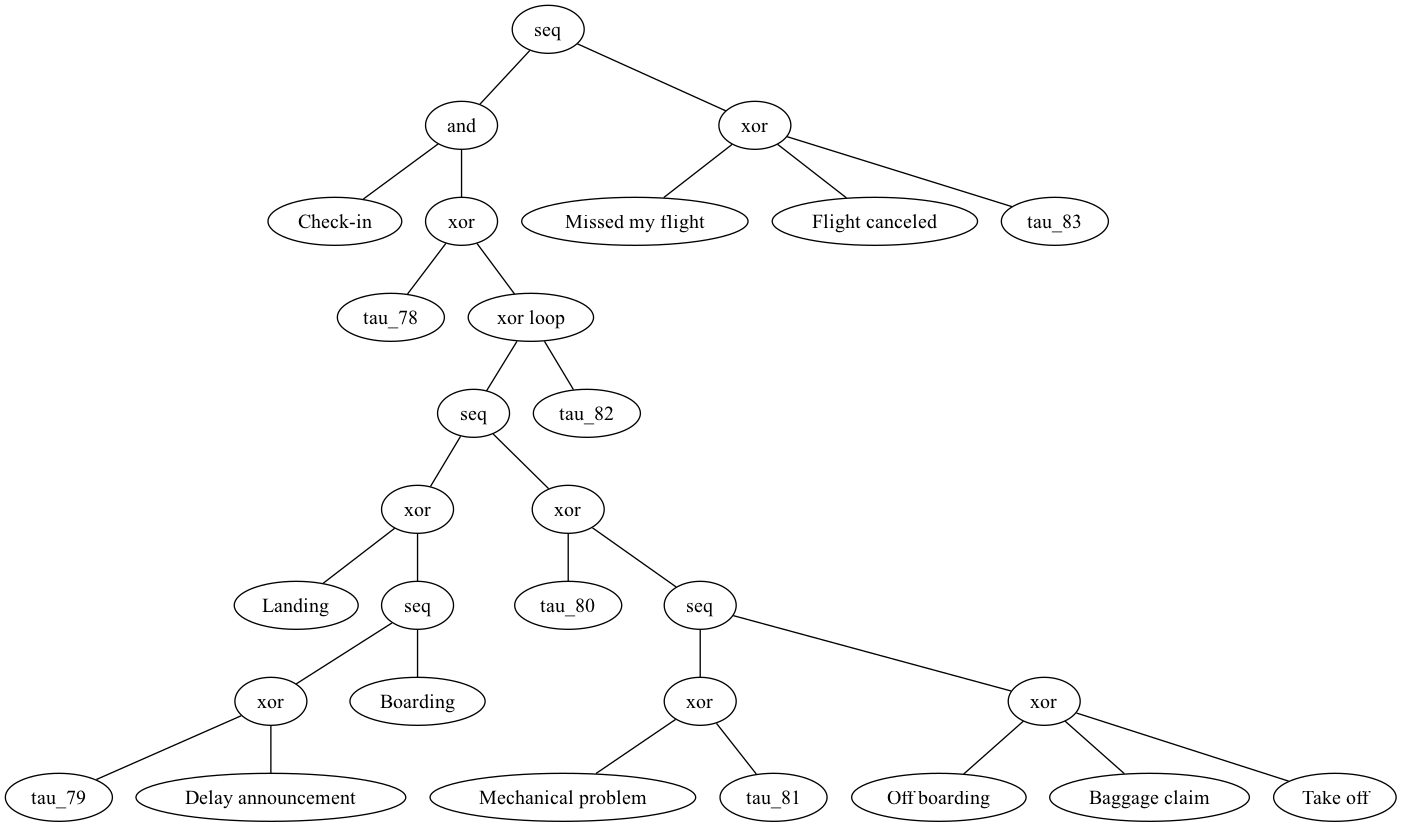

In [146]:
treee_small = view_process_tree_lr(log_small_data, 0)

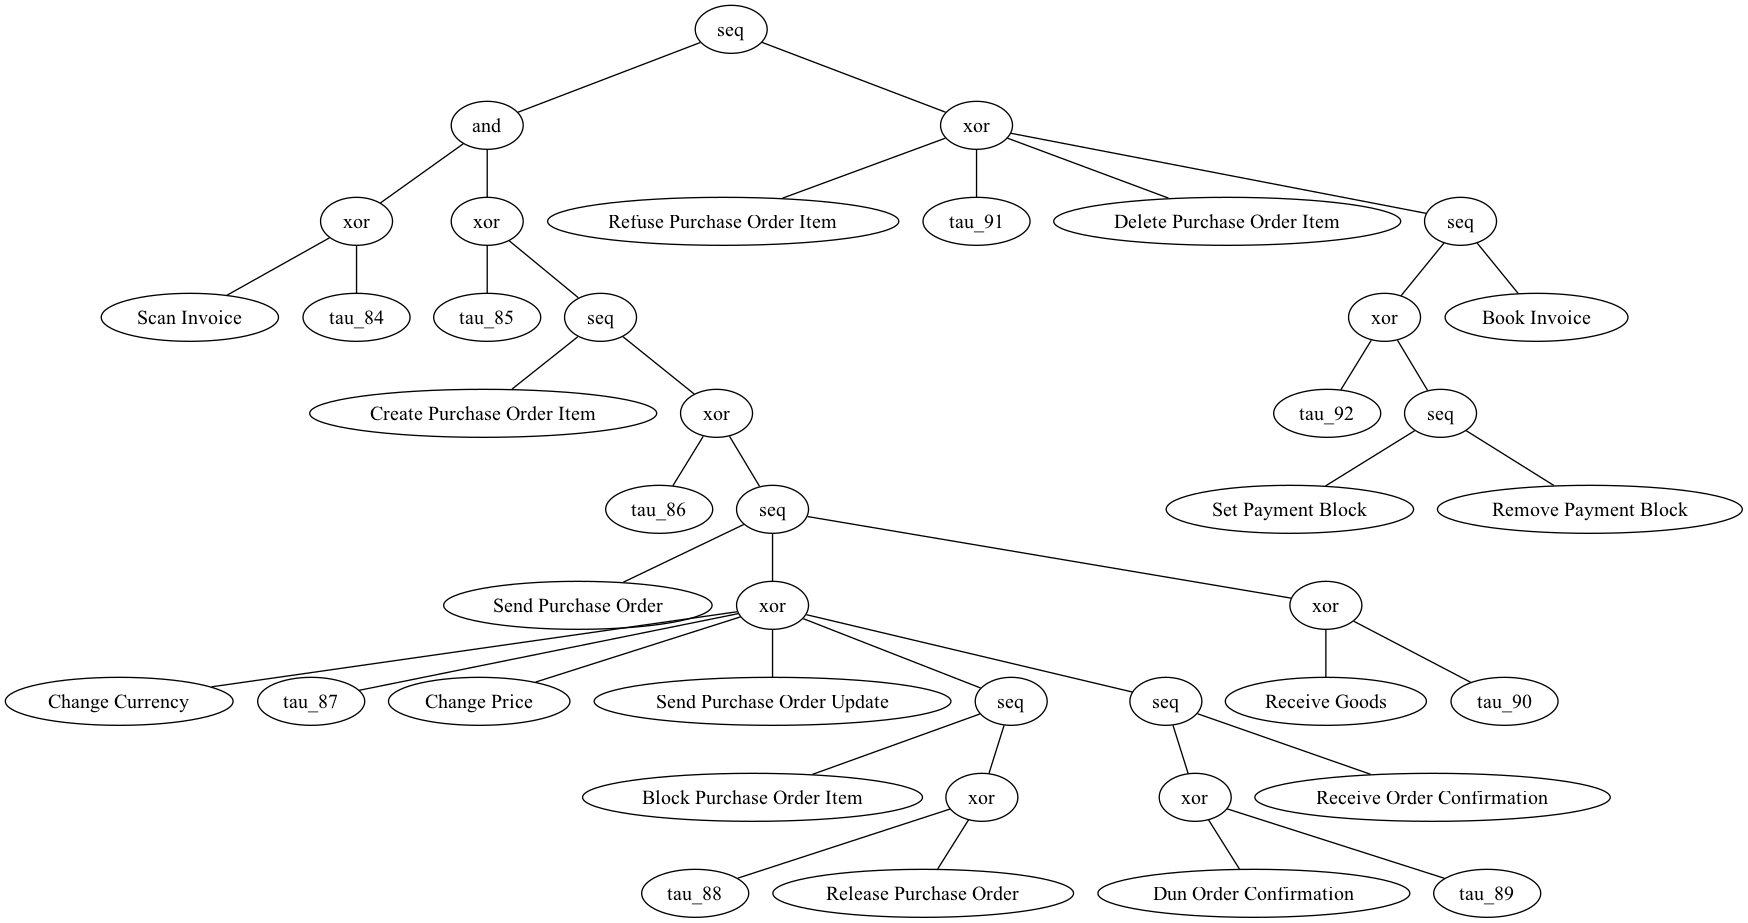

In [147]:
treee_medium = view_process_tree_lr(log_medium_data, 0)

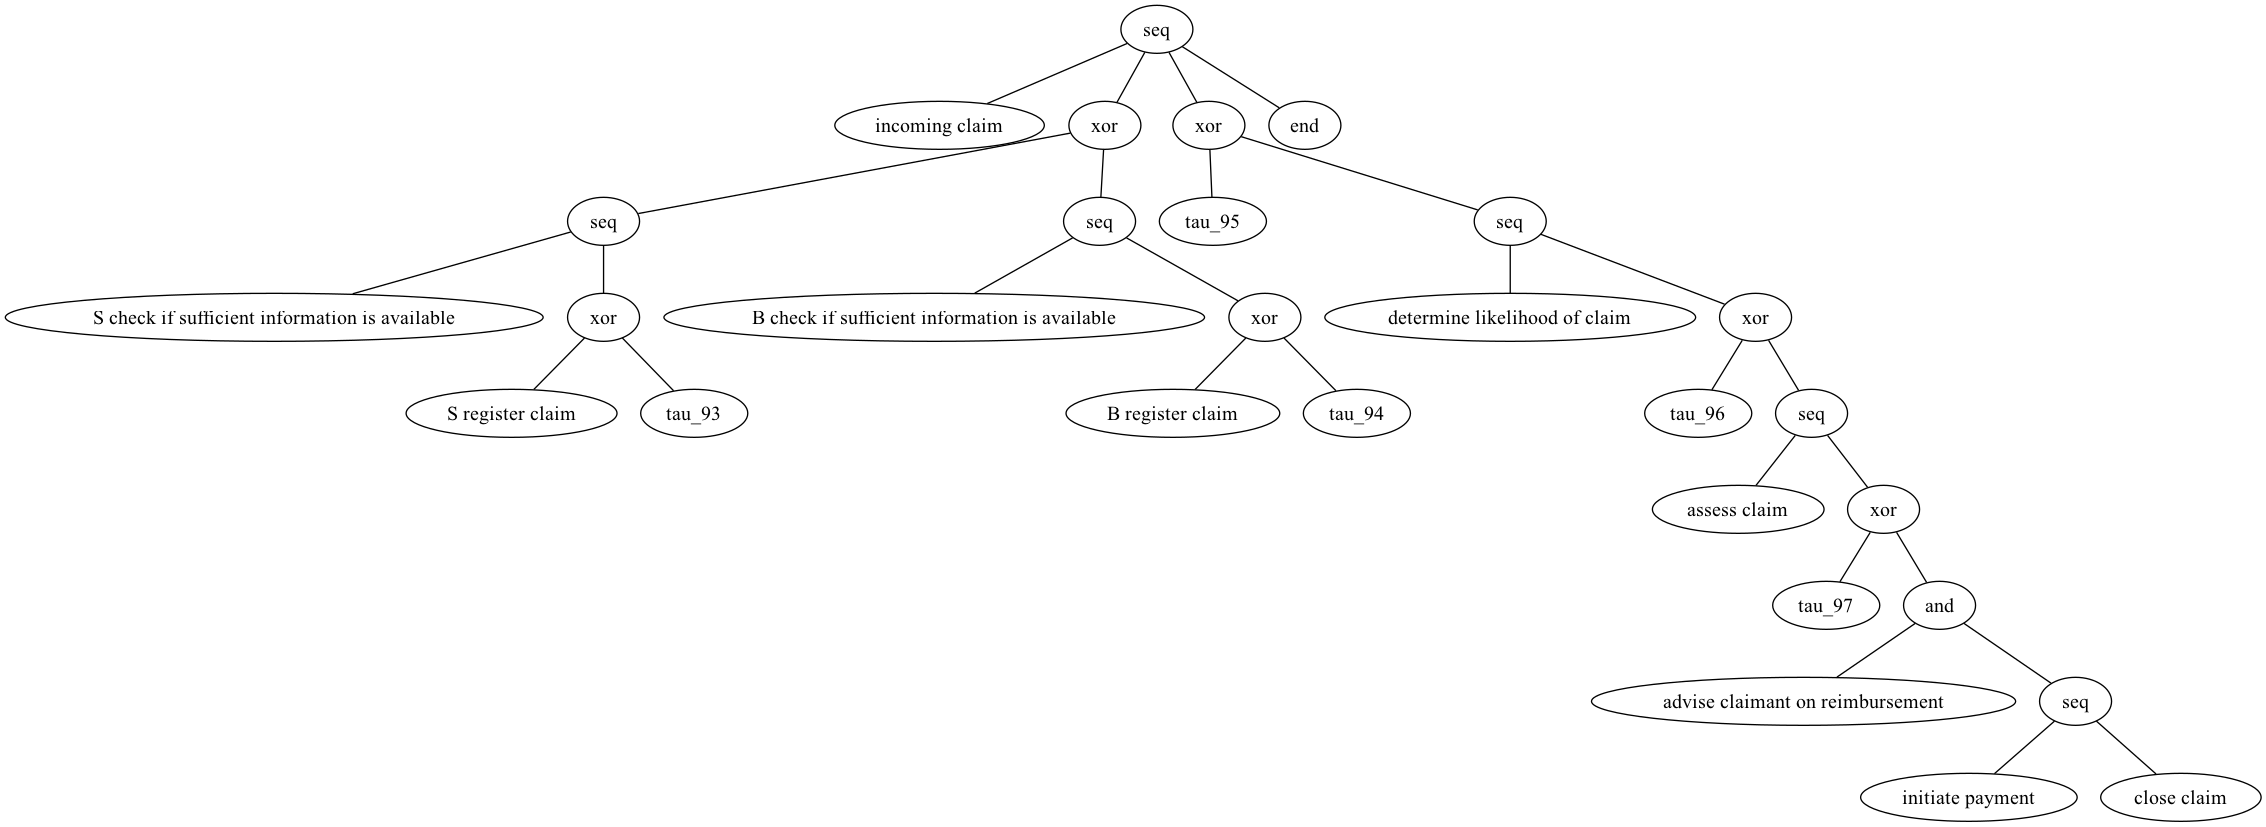

In [148]:
treee_big = view_process_tree_lr(log_big_data, 0)

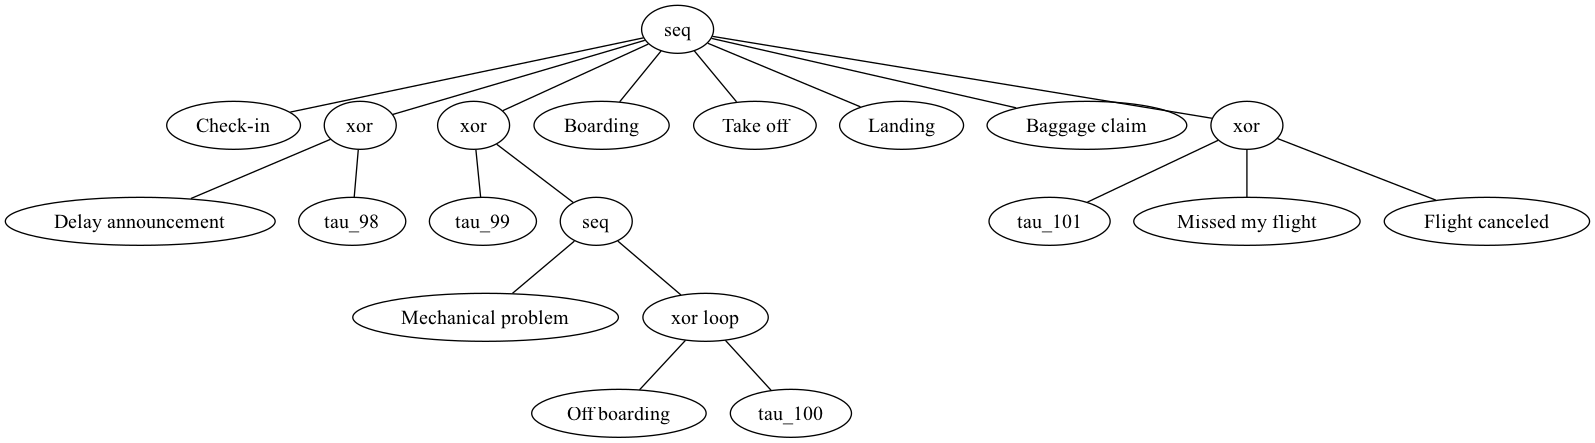

In [149]:
treee_small_1 = view_process_tree_lr(log_small_data, 0.5)

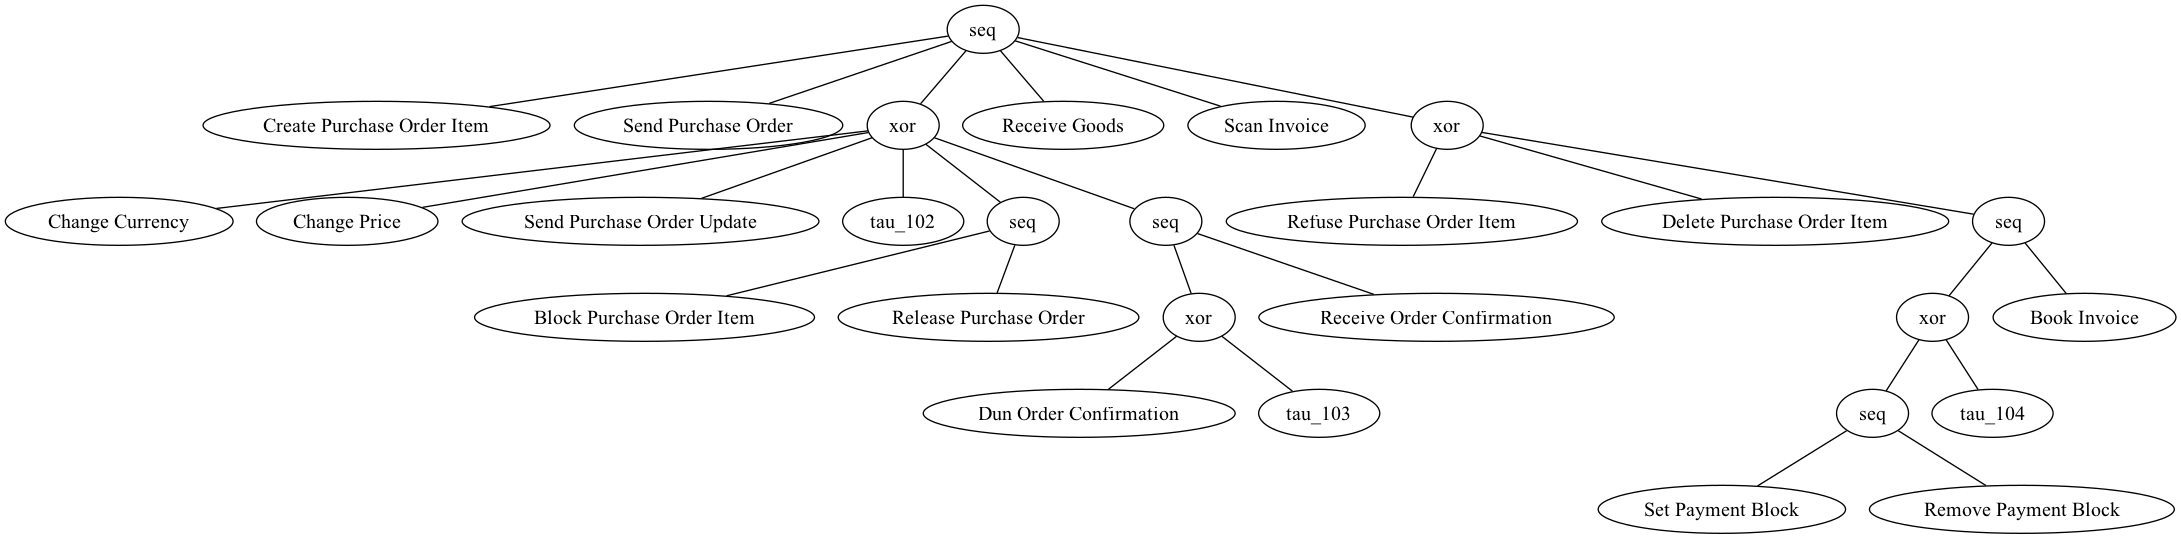

In [150]:
treee_medium_1 = view_process_tree_lr(log_medium_data, 0.5)

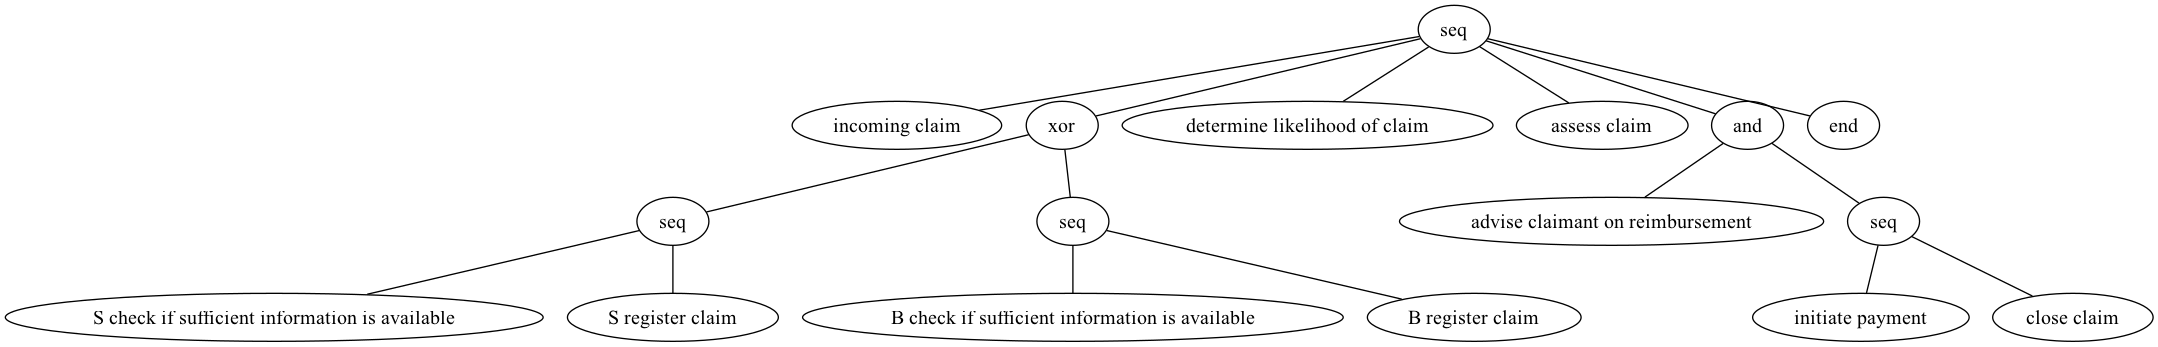

In [151]:
treee_big_1 = view_process_tree_lr(log_big_data, 0.5)

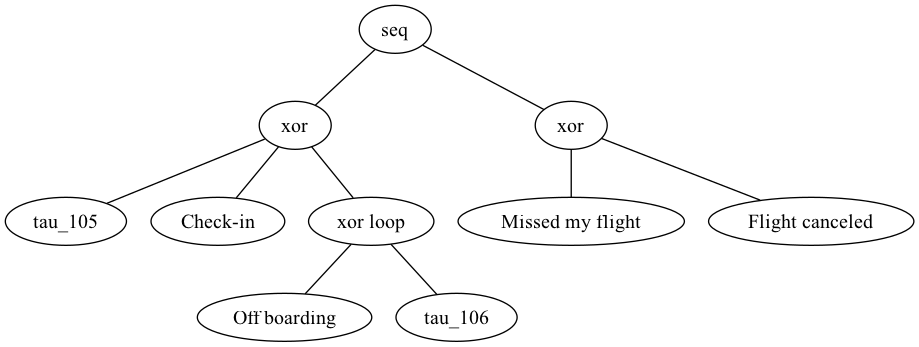

In [152]:
treee_small_2 = view_process_tree_lr(log_small_data, 1)

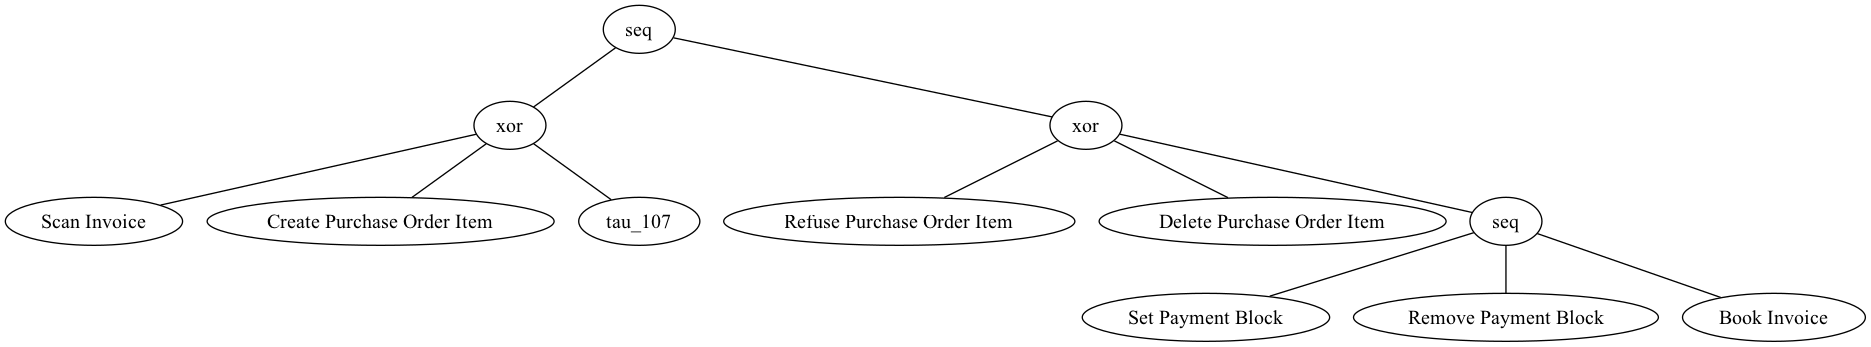

In [153]:
treee_medium_2 = view_process_tree_lr(log_medium_data, 1)

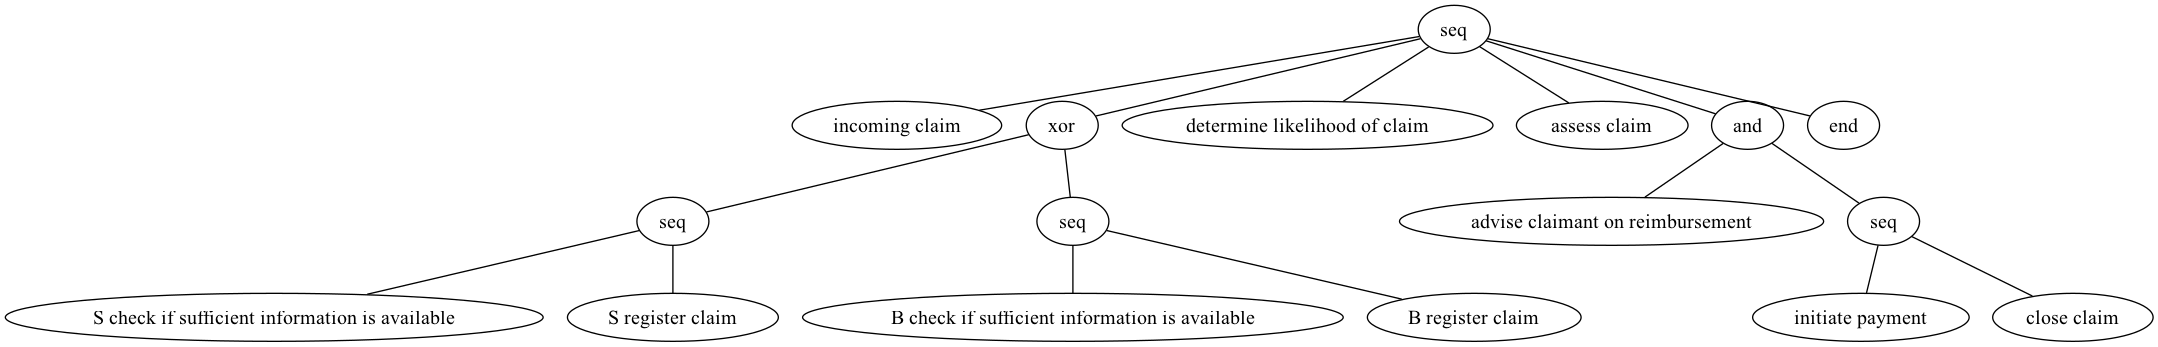

In [154]:
treee_big_2 = view_process_tree_lr(log_big_data, 1)

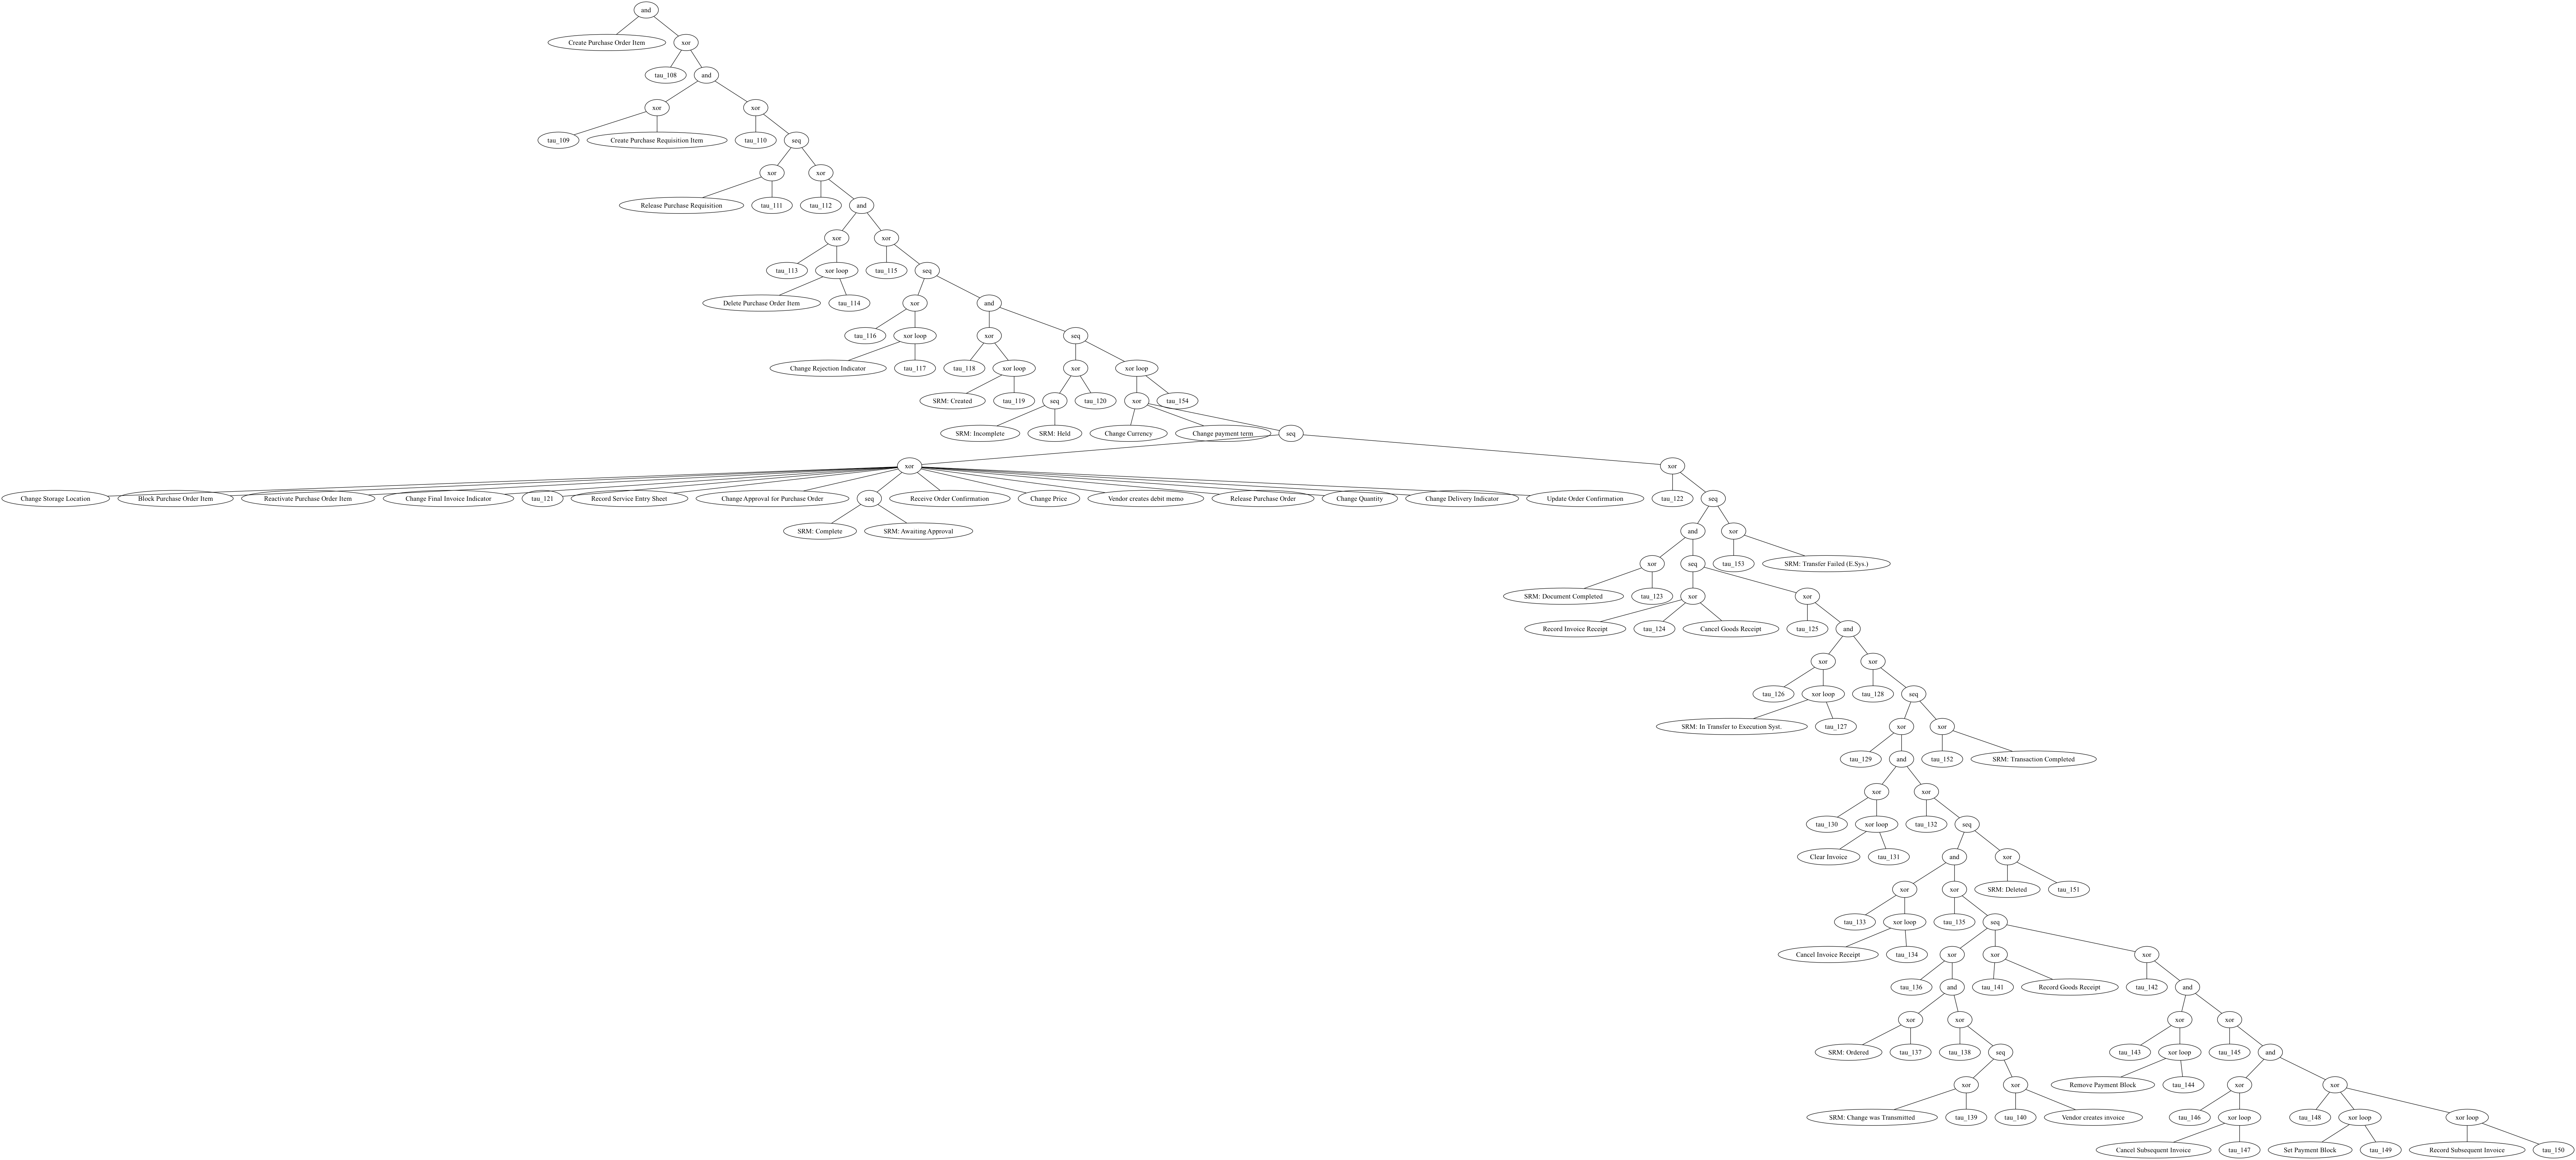

In [155]:
treee_BPI = view_process_tree_lr(BPI_data, 0)

### AST

Defines classes for preparing AST structure

In [156]:
class ASTNode(ABC):
    @abstractmethod
    def to_string(self, depth: int = 0) -> str:
        pass

class LiteralASTNode(ASTNode):
    def __init__(self, label: str):
        self.label = label

    def to_string(self, depth: int = 0) -> str:
        indent = "    " * depth
        return f"{indent}Literal: '{self.label}'"

class OperatorASTNode(ASTNode):
    def __init__(self, operator: str, children: List[ASTNode]):
        self.operator = operator
        self.children = children

    def to_string(self, depth: int = 0) -> str:
        indent = "    " * depth
        child_str = "\n".join(child.to_string(depth + 1) for child in self.children)
        return f"{indent}Operator: {self.operator}\n{child_str}"

def process_tree_to_ast(pt: Any) -> ASTNode:
    if hasattr(pt, "children") and pt.children:
        op = getattr(pt, "operator", None) or "Seq"
        children_ast = [process_tree_to_ast(c) for c in pt.children]
        return OperatorASTNode(operator=str(op), children=children_ast)
    else:
        label = getattr(pt, "label", None) or "tau"
        return LiteralASTNode(label=str(label))

In [157]:
ast_tree_small = process_tree_to_ast(treee_small)
print(ast_tree_small.to_string())

Operator: ->
    Operator: +
        Literal: 'Check-in'
        Operator: X
            Literal: 'tau_78'
            Operator: *
                Operator: ->
                    Operator: X
                        Literal: 'Landing'
                        Operator: ->
                            Operator: X
                                Literal: 'tau_79'
                                Literal: 'Delay announcement'
                            Literal: 'Boarding'
                    Operator: X
                        Literal: 'tau_80'
                        Operator: ->
                            Operator: X
                                Literal: 'tau_81'
                                Literal: 'Mechanical problem'
                            Operator: X
                                Literal: 'Off boarding'
                                Literal: 'Baggage claim'
                                Literal: 'Take off'
                Literal: 'tau_82'
    Operator: X
        Li

In [158]:
ast_tree_small_1 = process_tree_to_ast(treee_small_1)
print(ast_tree_small_1.to_string())

Operator: ->
    Literal: 'Check-in'
    Operator: X
        Literal: 'tau_98'
        Literal: 'Delay announcement'
    Operator: X
        Literal: 'tau_99'
        Operator: ->
            Literal: 'Mechanical problem'
            Operator: *
                Literal: 'Off boarding'
                Literal: 'tau_100'
    Literal: 'Boarding'
    Literal: 'Take off'
    Literal: 'Landing'
    Literal: 'Baggage claim'
    Operator: X
        Literal: 'tau_101'
        Literal: 'Missed my flight'
        Literal: 'Flight canceled'


In [159]:
ast_tree_small_2 = process_tree_to_ast(treee_small_2)
print(ast_tree_small_2.to_string())

Operator: ->
    Operator: X
        Literal: 'tau_105'
        Operator: *
            Literal: 'Off boarding'
            Literal: 'tau_106'
        Literal: 'Check-in'
    Operator: X
        Literal: 'Missed my flight'
        Literal: 'Flight canceled'


In [160]:
ast_tree_medium = process_tree_to_ast(treee_medium)
print(ast_tree_medium.to_string())

Operator: ->
    Operator: +
        Operator: X
            Literal: 'tau_84'
            Literal: 'Scan Invoice'
        Operator: X
            Literal: 'tau_85'
            Operator: ->
                Literal: 'Create Purchase Order Item'
                Operator: X
                    Literal: 'tau_86'
                    Operator: ->
                        Literal: 'Send Purchase Order'
                        Operator: X
                            Literal: 'tau_87'
                            Literal: 'Change Currency'
                            Literal: 'Change Price'
                            Literal: 'Send Purchase Order Update'
                            Operator: ->
                                Literal: 'Block Purchase Order Item'
                                Operator: X
                                    Literal: 'tau_88'
                                    Literal: 'Release Purchase Order'
                            Operator: ->
                            

In [161]:
ast_tree_medium_1 = process_tree_to_ast(treee_medium_1)
print(ast_tree_medium_1.to_string())

Operator: ->
    Literal: 'Create Purchase Order Item'
    Literal: 'Send Purchase Order'
    Operator: X
        Literal: 'tau_102'
        Literal: 'Change Currency'
        Literal: 'Change Price'
        Literal: 'Send Purchase Order Update'
        Operator: ->
            Literal: 'Block Purchase Order Item'
            Literal: 'Release Purchase Order'
        Operator: ->
            Operator: X
                Literal: 'tau_103'
                Literal: 'Dun Order Confirmation'
            Literal: 'Receive Order Confirmation'
    Literal: 'Receive Goods'
    Literal: 'Scan Invoice'
    Operator: X
        Literal: 'Refuse Purchase Order Item'
        Literal: 'Delete Purchase Order Item'
        Operator: ->
            Operator: X
                Literal: 'tau_104'
                Operator: ->
                    Literal: 'Set Payment Block'
                    Literal: 'Remove Payment Block'
            Literal: 'Book Invoice'


In [162]:
ast_tree_medium_2 = process_tree_to_ast(treee_medium_2)
print(ast_tree_medium_2.to_string())

Operator: ->
    Operator: X
        Literal: 'tau_107'
        Literal: 'Scan Invoice'
        Literal: 'Create Purchase Order Item'
    Operator: X
        Literal: 'Refuse Purchase Order Item'
        Literal: 'Delete Purchase Order Item'
        Operator: ->
            Literal: 'Set Payment Block'
            Literal: 'Remove Payment Block'
            Literal: 'Book Invoice'


In [163]:
ast_tree_big = process_tree_to_ast(treee_big)
print(ast_tree_big.to_string())

Operator: ->
    Literal: 'incoming claim'
    Operator: X
        Operator: ->
            Literal: 'S check if sufficient information is available'
            Operator: X
                Literal: 'tau_93'
                Literal: 'S register claim'
        Operator: ->
            Literal: 'B check if sufficient information is available'
            Operator: X
                Literal: 'tau_94'
                Literal: 'B register claim'
    Operator: X
        Literal: 'tau_95'
        Operator: ->
            Literal: 'determine likelihood of claim'
            Operator: X
                Literal: 'tau_96'
                Operator: ->
                    Literal: 'assess claim'
                    Operator: X
                        Literal: 'tau_97'
                        Operator: +
                            Literal: 'advise claimant on reimbursement'
                            Operator: ->
                                Literal: 'initiate payment'
                         

In [164]:
ast_tree_big_1 = process_tree_to_ast(treee_big_1)
print(ast_tree_big_1.to_string())

Operator: ->
    Literal: 'incoming claim'
    Operator: X
        Operator: ->
            Literal: 'S check if sufficient information is available'
            Literal: 'S register claim'
        Operator: ->
            Literal: 'B check if sufficient information is available'
            Literal: 'B register claim'
    Literal: 'determine likelihood of claim'
    Literal: 'assess claim'
    Operator: +
        Literal: 'advise claimant on reimbursement'
        Operator: ->
            Literal: 'initiate payment'
            Literal: 'close claim'
    Literal: 'end'


In [165]:
ast_tree_big_2 = process_tree_to_ast(treee_big_2)
print(ast_tree_big_2.to_string())

Operator: ->
    Literal: 'incoming claim'
    Operator: X
        Operator: ->
            Literal: 'S check if sufficient information is available'
            Literal: 'S register claim'
        Operator: ->
            Literal: 'B check if sufficient information is available'
            Literal: 'B register claim'
    Literal: 'determine likelihood of claim'
    Literal: 'assess claim'
    Operator: +
        Literal: 'advise claimant on reimbursement'
        Operator: ->
            Literal: 'initiate payment'
            Literal: 'close claim'
    Literal: 'end'


In [166]:
ast_tree_BPI = process_tree_to_ast(treee_BPI)
print(ast_tree_BPI.to_string())

Operator: +
    Literal: 'Create Purchase Order Item'
    Operator: X
        Literal: 'tau_108'
        Operator: +
            Operator: X
                Literal: 'tau_109'
                Literal: 'Create Purchase Requisition Item'
            Operator: X
                Literal: 'tau_110'
                Operator: ->
                    Operator: X
                        Literal: 'tau_111'
                        Literal: 'Release Purchase Requisition'
                    Operator: X
                        Literal: 'tau_112'
                        Operator: +
                            Operator: X
                                Literal: 'tau_113'
                                Operator: *
                                    Literal: 'Delete Purchase Order Item'
                                    Literal: 'tau_114'
                            Operator: X
                                Literal: 'tau_115'
                                Operator: ->
                          

### Visitor

Defines visitor for generating logical specification

In [167]:
class ASTVisitor(ABC):
    @abstractmethod
    def visit_literal(self, node: LiteralASTNode):
        pass

    @abstractmethod
    def visit_operator(self, node: OperatorASTNode):
        pass

    def visit(self, node: ASTNode) -> Union[str, List[str]]:
        if isinstance(node, LiteralASTNode):
            lit = cast(LiteralASTNode, node)
            return self.visit_literal(lit)
        elif isinstance(node, OperatorASTNode):
            op = cast(OperatorASTNode, node)
            return self.visit_operator(op)
        else:
            ...

class LogicalSpecificationVisitor(ASTVisitor):
    def visit_literal(self, node: LiteralASTNode):
        return f"'{node.label}'"

    def visit_operator(self, node: OperatorASTNode):
        op = node.operator.lower()
        if op == "seq":
            if len(node.children) == 2:
                ini = self.visit(node.children[0])
                fin = self.visit(node.children[1])
                return [
                    f"{ini} => <> {fin}",
                    f"~{ini} => ~<> {fin}",
                    f"[]~({ini} & {fin})"
                ]
            else:
                return [
                    f"{self.visit(node.children[i])} => <> {self.visit(node.children[i+1])}"
                    for i in range(len(node.children)-1)
                ]
        else:
            parts = []
            for c in node.children:
                r = self.visit(c)
                parts.append(r[0] if isinstance(r, list) else r)
            args_str = ", ".join(parts)
            return [f"{node.operator}({args_str})"]

### Create visitor

In [168]:
visitor = LogicalSpecificationVisitor()

### Specification Processing

- to lowercase
- replacing
- further labelling

In [169]:
import re

class Format:
    @staticmethod
    def lowercase_in_quotes(s: str) -> str:
        def _repl(m: re.Match) -> str:
            inner = m.group(1)
            return f"'{inner.lower()}'"
        return re.sub(r"'([^']*)'", _repl, s)

    @staticmethod
    def replace_parens_in_quotes(s: str) -> str:
        def _repl(m: re.Match) -> str:
            inner = m.group(1)
            inner = inner.replace('(', '-').replace(')', '-')
            return f"'{inner}'"
        return re.sub(r"'([^']*)'", _repl, s)

    @staticmethod
    def replace_colons_in_quotes(s: str) -> str:
        def _repl(match):
            inner = match.group(1)
            return f"'{inner.replace(':', '_')}'"
        return re.sub(r"'([^']*)'", _repl, s)

    @staticmethod
    def replace_spaces_with_underscore(tree):
        def replace_spaces(match):
            return re.sub(r'\s+', '_', match.group(0))

        text_with_underscore = re.sub(r"'(.*?)'", replace_spaces, tree)
        text_no_quotes = re.sub(r"'", '', text_with_underscore)

        return text_no_quotes

    @staticmethod
    def label_expressions(expression: str) -> str:
        labelled_expression = ""
        label_number = 0
        for c in expression:
            if c == '(':
                label_number += 1
                labelled_expression += f"({label_number}]"
            elif c == ')':
                labelled_expression += f"[{label_number})"
                label_number -= 1
            else:
                labelled_expression += c
        return labelled_expression

In [235]:
def labelling(ast_tree):
    spec = visitor.visit(ast_tree)

    out = "\n".join(str(f) for f in spec)
    print(out)

    out = Format.lowercase_in_quotes(out)
    print(out)

    out = Format.replace_parens_in_quotes(out)
    print(out)

    out = Format.replace_colons_in_quotes(out)
    print(out)

    out_s = Format.replace_spaces_with_underscore(out)
    out_l = Format.label_expressions(out_s)
    print(out_l)

    return out_l

In [238]:
small_l = labelling(ast_tree_small)

->(+('Check-in', X('tau_78', *(->(X('Landing', ->(X('tau_79', 'Delay announcement'), 'Boarding')), X('tau_80', ->(X('tau_81', 'Mechanical problem'), X('Off boarding', 'Baggage claim', 'Take off')))), 'tau_82'))), X('tau_83', 'Missed my flight', 'Flight canceled'))
->(+('check-in', X('tau_78', *(->(X('landing', ->(X('tau_79', 'delay announcement'), 'boarding')), X('tau_80', ->(X('tau_81', 'mechanical problem'), X('off boarding', 'baggage claim', 'take off')))), 'tau_82'))), X('tau_83', 'missed my flight', 'flight canceled'))
->(+('check-in', X('tau_78', *(->(X('landing', ->(X('tau_79', 'delay announcement'), 'boarding')), X('tau_80', ->(X('tau_81', 'mechanical problem'), X('off boarding', 'baggage claim', 'take off')))), 'tau_82'))), X('tau_83', 'missed my flight', 'flight canceled'))
->(+('check-in', X('tau_78', *(->(X('landing', ->(X('tau_79', 'delay announcement'), 'boarding')), X('tau_80', ->(X('tau_81', 'mechanical problem'), X('off boarding', 'baggage claim', 'take off')))), 'tau_

In [239]:
small1_l = labelling(ast_tree_small_1)

->('Check-in', X('tau_98', 'Delay announcement'), X('tau_99', ->('Mechanical problem', *('Off boarding', 'tau_100'))), 'Boarding', 'Take off', 'Landing', 'Baggage claim', X('tau_101', 'Missed my flight', 'Flight canceled'))
->('check-in', X('tau_98', 'delay announcement'), X('tau_99', ->('mechanical problem', *('off boarding', 'tau_100'))), 'boarding', 'take off', 'landing', 'baggage claim', X('tau_101', 'missed my flight', 'flight canceled'))
->('check-in', X('tau_98', 'delay announcement'), X('tau_99', ->('mechanical problem', *('off boarding', 'tau_100'))), 'boarding', 'take off', 'landing', 'baggage claim', X('tau_101', 'missed my flight', 'flight canceled'))
->('check-in', X('tau_98', 'delay announcement'), X('tau_99', ->('mechanical problem', *('off boarding', 'tau_100'))), 'boarding', 'take off', 'landing', 'baggage claim', X('tau_101', 'missed my flight', 'flight canceled'))
->(1]check-in, X(2]tau_98, delay_announcement[2), X(2]tau_99, ->(3]mechanical_problem, *(4]off_boarding,

In [240]:
small2_l = labelling(ast_tree_small_2)

->(X('tau_105', *('Off boarding', 'tau_106'), 'Check-in'), X('Missed my flight', 'Flight canceled'))
->(X('tau_105', *('off boarding', 'tau_106'), 'check-in'), X('missed my flight', 'flight canceled'))
->(X('tau_105', *('off boarding', 'tau_106'), 'check-in'), X('missed my flight', 'flight canceled'))
->(X('tau_105', *('off boarding', 'tau_106'), 'check-in'), X('missed my flight', 'flight canceled'))
->(1]X(2]tau_105, *(3]off_boarding, tau_106[3), check-in[2), X(2]missed_my_flight, flight_canceled[2)[1)


In [241]:
medium_l = labelling(ast_tree_medium)

->(+(X('tau_84', 'Scan Invoice'), X('tau_85', ->('Create Purchase Order Item', X('tau_86', ->('Send Purchase Order', X('tau_87', 'Change Currency', 'Change Price', 'Send Purchase Order Update', ->('Block Purchase Order Item', X('tau_88', 'Release Purchase Order')), ->(X('tau_89', 'Dun Order Confirmation'), 'Receive Order Confirmation')), X('tau_90', 'Receive Goods')))))), X('tau_91', 'Refuse Purchase Order Item', 'Delete Purchase Order Item', ->(X('tau_92', ->('Set Payment Block', 'Remove Payment Block')), 'Book Invoice')))
->(+(X('tau_84', 'scan invoice'), X('tau_85', ->('create purchase order item', X('tau_86', ->('send purchase order', X('tau_87', 'change currency', 'change price', 'send purchase order update', ->('block purchase order item', X('tau_88', 'release purchase order')), ->(X('tau_89', 'dun order confirmation'), 'receive order confirmation')), X('tau_90', 'receive goods')))))), X('tau_91', 'refuse purchase order item', 'delete purchase order item', ->(X('tau_92', ->('set 

In [242]:
medium1_l = labelling(ast_tree_medium_1)

->('Create Purchase Order Item', 'Send Purchase Order', X('tau_102', 'Change Currency', 'Change Price', 'Send Purchase Order Update', ->('Block Purchase Order Item', 'Release Purchase Order'), ->(X('tau_103', 'Dun Order Confirmation'), 'Receive Order Confirmation')), 'Receive Goods', 'Scan Invoice', X('Refuse Purchase Order Item', 'Delete Purchase Order Item', ->(X('tau_104', ->('Set Payment Block', 'Remove Payment Block')), 'Book Invoice')))
->('create purchase order item', 'send purchase order', X('tau_102', 'change currency', 'change price', 'send purchase order update', ->('block purchase order item', 'release purchase order'), ->(X('tau_103', 'dun order confirmation'), 'receive order confirmation')), 'receive goods', 'scan invoice', X('refuse purchase order item', 'delete purchase order item', ->(X('tau_104', ->('set payment block', 'remove payment block')), 'book invoice')))
->('create purchase order item', 'send purchase order', X('tau_102', 'change currency', 'change price', 's

In [243]:
medium2_l = labelling(ast_tree_medium_2)

->(X('tau_107', 'Scan Invoice', 'Create Purchase Order Item'), X('Refuse Purchase Order Item', 'Delete Purchase Order Item', ->('Set Payment Block', 'Remove Payment Block', 'Book Invoice')))
->(X('tau_107', 'scan invoice', 'create purchase order item'), X('refuse purchase order item', 'delete purchase order item', ->('set payment block', 'remove payment block', 'book invoice')))
->(X('tau_107', 'scan invoice', 'create purchase order item'), X('refuse purchase order item', 'delete purchase order item', ->('set payment block', 'remove payment block', 'book invoice')))
->(X('tau_107', 'scan invoice', 'create purchase order item'), X('refuse purchase order item', 'delete purchase order item', ->('set payment block', 'remove payment block', 'book invoice')))
->(1]X(2]tau_107, scan_invoice, create_purchase_order_item[2), X(2]refuse_purchase_order_item, delete_purchase_order_item, ->(3]set_payment_block, remove_payment_block, book_invoice[3)[2)[1)


In [244]:
big_l = labelling(ast_tree_big)

->('incoming claim', X(->('S check if sufficient information is available', X('tau_93', 'S register claim')), ->('B check if sufficient information is available', X('tau_94', 'B register claim'))), X('tau_95', ->('determine likelihood of claim', X('tau_96', ->('assess claim', X('tau_97', +('advise claimant on reimbursement', ->('initiate payment', 'close claim'))))))), 'end')
->('incoming claim', X(->('s check if sufficient information is available', X('tau_93', 's register claim')), ->('b check if sufficient information is available', X('tau_94', 'b register claim'))), X('tau_95', ->('determine likelihood of claim', X('tau_96', ->('assess claim', X('tau_97', +('advise claimant on reimbursement', ->('initiate payment', 'close claim'))))))), 'end')
->('incoming claim', X(->('s check if sufficient information is available', X('tau_93', 's register claim')), ->('b check if sufficient information is available', X('tau_94', 'b register claim'))), X('tau_95', ->('determine likelihood of clai

In [245]:
big1_l = labelling(ast_tree_big_1)

->('incoming claim', X(->('S check if sufficient information is available', 'S register claim'), ->('B check if sufficient information is available', 'B register claim')), 'determine likelihood of claim', 'assess claim', +('advise claimant on reimbursement', ->('initiate payment', 'close claim')), 'end')
->('incoming claim', X(->('s check if sufficient information is available', 's register claim'), ->('b check if sufficient information is available', 'b register claim')), 'determine likelihood of claim', 'assess claim', +('advise claimant on reimbursement', ->('initiate payment', 'close claim')), 'end')
->('incoming claim', X(->('s check if sufficient information is available', 's register claim'), ->('b check if sufficient information is available', 'b register claim')), 'determine likelihood of claim', 'assess claim', +('advise claimant on reimbursement', ->('initiate payment', 'close claim')), 'end')
->('incoming claim', X(->('s check if sufficient information is available', 's reg

In [246]:
big2_l = labelling(ast_tree_big_2)

->('incoming claim', X(->('S check if sufficient information is available', 'S register claim'), ->('B check if sufficient information is available', 'B register claim')), 'determine likelihood of claim', 'assess claim', +('advise claimant on reimbursement', ->('initiate payment', 'close claim')), 'end')
->('incoming claim', X(->('s check if sufficient information is available', 's register claim'), ->('b check if sufficient information is available', 'b register claim')), 'determine likelihood of claim', 'assess claim', +('advise claimant on reimbursement', ->('initiate payment', 'close claim')), 'end')
->('incoming claim', X(->('s check if sufficient information is available', 's register claim'), ->('b check if sufficient information is available', 'b register claim')), 'determine likelihood of claim', 'assess claim', +('advise claimant on reimbursement', ->('initiate payment', 'close claim')), 'end')
->('incoming claim', X(->('s check if sufficient information is available', 's reg

In [ ]:
BPI_l = labelling(ast_tree_BPI)

+('Create Purchase Order Item', X('tau_108', +(X('tau_109', 'Create Purchase Requisition Item'), X('tau_110', ->(X('tau_111', 'Release Purchase Requisition'), X('tau_112', +(X('tau_113', *('Delete Purchase Order Item', 'tau_114')), X('tau_115', ->(X('tau_116', *('Change Rejection Indicator', 'tau_117')), +(X('tau_118', *('SRM: Created', 'tau_119')), ->(X('tau_120', ->('SRM: Incomplete', 'SRM: Held')), *(X('Change Currency', 'Change payment term', ->(X('tau_121', 'Change Storage Location', 'Block Purchase Order Item', 'Reactivate Purchase Order Item', 'Change Final Invoice Indicator', 'Record Service Entry Sheet', 'Change Approval for Purchase Order', ->('SRM: Complete', 'SRM: Awaiting Approval'), 'Receive Order Confirmation', 'Change Price', 'Vendor creates debit memo', 'Release Purchase Order', 'Change Quantity', 'Change Delivery Indicator', 'Update Order Confirmation'), X('tau_122', ->(+(X('tau_123', 'SRM: Document Completed'), ->(X('tau_124', 'Record Invoice Receipt', 'Cancel Goods 

### Adapter

In [249]:
class ProcessTreeAdapter:
    @staticmethod
    def extract_arguments_from_labelled_expression(labelled_expression):
        pattern_label_number = int(labelled_expression[labelled_expression.index(
            "(") + 1:labelled_expression.index("]")])
        trimmed_labelled_expression = labelled_expression[labelled_expression.index("]") + 1: list(re.finditer(r'\[', labelled_expression))[-1].start()]
        split = trimmed_labelled_expression.split(",")
        arguments = []
        brackets_counter = 0
        temp_arg = ""
        for s in split:
            brackets_counter += s.count('(')
            brackets_counter -= s.count(')')
            temp_arg += s + ","
            if brackets_counter == 0:
                temp_arg = temp_arg[:-1]
                arguments.append(temp_arg)
                temp_arg = ""
        return arguments, pattern_label_number

    @staticmethod
    def find_symbol(labelled_expression):
        pattern = r'^[^()]*'
        match = re.match(pattern, labelled_expression)
        if match:
            return re.sub(r'\s+', '', match.group())
        else:
            raise Exception("No match")

    @staticmethod
    def replace_symbol_with_name(labelled_pattern_expression, pattern_label_number, old_symbol, new_name):
        pattern = rf"{re.escape(old_symbol)}\(\s*{pattern_label_number}\s*\]"
        final_name = f"{new_name}({pattern_label_number}]"
        replaced_string = re.sub(pattern, final_name, labelled_pattern_expression, count=1)

        return replaced_string

    @staticmethod
    def get_highest_label(labelledExpression: str) -> int:
        maxLabel = -1
        active = False
        sb = ""
        for c in labelledExpression:
            if c == '(':
                active = True
            elif c == ']':
                if int(sb) > maxLabel:
                    maxLabel = int(sb)
                sb = ""
                active = False
            elif active:
                sb += c
        return maxLabel

### Definitions

- Sequence
- Loop
- Exclusive choice
- Parallelism

In [250]:
class Sequence:
    _counter = defaultdict(int)

    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        n = len(labelled_expression)
        if not (2 <= n <= 10):
            raise Exception(f"Pattern for Seq{n} does not exist")

        Sequence._counter[n] += 1

        pattern_name = f'Seq{n}'
        old = f"({pattern_label_number}]" + ",".join(labelled_expression) + f"[{pattern_label_number})"
        new = old

        return pattern_name, old, new


class Loop:
    _counter = defaultdict(int)

    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        n = len(labelled_expression)
        if not (2 <= n <= 30):
            raise Exception(f"Pattern for Loop{n} does not exist")

        Loop._counter[n] += 1
        idx = Loop._counter[n]

        pattern_name = f'Loop{n}'
        old = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"

        start = f'l{n}_s_{idx}'
        end   = f'l{n}_e_{idx}'
        labelled_expression = [start] + labelled_expression + [end]

        new = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        return pattern_name, old, new


class ExclusiveChoice:
    _counter = defaultdict(int)

    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        n = len(labelled_expression)
        if not (2 <= n <= 30):
            raise Exception(f"Pattern for Xor{n} does not exist")

        ExclusiveChoice._counter[n] += 1
        idx = ExclusiveChoice._counter[n]
        pattern_name = f'Xor{n}'
        labelled_expression_to_replace = "(" + str(pattern_label_number) + "]" + ",".join(
            labelled_expression) + "[" + str(pattern_label_number) + ")"

        start = f'x{n}_s_{idx}'
        end   = f'x{n}_e_{idx}'
        labelled_expression = [start] + labelled_expression + [end]

        new_labelled_expression = "(" + str(pattern_label_number) + "]" + ",".join(
            labelled_expression) + "[" + str(pattern_label_number) + ")"
        return pattern_name, labelled_expression_to_replace, new_labelled_expression


class Parallelism:
    _counter = defaultdict(int)

    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        n = len(labelled_expression)

        if not (2 <= n <= 30):
            raise Exception(f"Pattern for And{n} does not exist")

        Parallelism._counter[n] += 1
        idx = Parallelism._counter[n]

        pattern_name = f'And{n}'
        labelled_expression_to_replace = "(" + str(pattern_label_number) + "]" + ",".join(
            labelled_expression) + "[" + str(pattern_label_number) + ")"

        start = f'a{n}_s_{idx}'
        end   = f'a{n}_e_{idx}'
        labelled_expression = [start] + labelled_expression + [end]

        new_labelled_expression = "(" + str(pattern_label_number) + "]" + ",".join(
            labelled_expression) + "[" + str(pattern_label_number) + ")"
        return pattern_name, labelled_expression_to_replace, new_labelled_expression


### Generating expressions with labelling

In [183]:
class PatternExpressionGenerator:
    def __init__(self, converted_expression):
        self.converted_expression = converted_expression

    def add_approved_workflow_patterns(self, expression):
        if expression is None or isinstance(expression, list):
            return

        symbol = ProcessTreeAdapter.find_symbol(expression)
        up = symbol.upper()
        if up.startswith("SEQ"):
            symbol = "->"
        elif up.startswith("AND"):
            symbol = "+"
        elif up.startswith("XOR"):
            symbol = "X"
        elif up.startswith("LOOP"):
            symbol = "*"

        pattern = r'>|X|\+|\*'
        matches = re.findall(pattern, expression)

        if len(matches) != 0:
            arguments = ProcessTreeAdapter.extract_arguments_from_labelled_expression(
                expression)
            expression = arguments[0]
            pattern_label_number = arguments[1]

            if symbol == '->' or symbol.upper().startswith("SEQ"):
                new_name = Sequence.change_symbol_into_name(expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(
                    self.converted_expression, pattern_label_number, symbol, new_name[0])
                expr_tmp = self.converted_expression
                self.converted_expression = expr_tmp.replace(new_name[1], new_name[2])

            elif symbol == '*' or symbol.upper().startswith("LOOP"):
                new_name = Loop.change_symbol_into_name(
                    expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(
                    self.converted_expression, pattern_label_number, symbol, new_name[0])
                self.converted_expression = self.converted_expression.replace(
                    new_name[1], new_name[2])

            elif symbol == '+' or symbol.upper().startswith("AND"):
                new_name = Parallelism.change_symbol_into_name(
                    expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(
                    self.converted_expression, pattern_label_number, symbol, new_name[0])
                self.converted_expression = self.converted_expression.replace(
                    new_name[1], new_name[2])

            elif symbol == 'X' or symbol.upper().startswith("XOR"):
                new_name = ExclusiveChoice.change_symbol_into_name(
                    expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(
                    self.converted_expression, pattern_label_number, symbol, new_name[0])
                self.converted_expression = self.converted_expression.replace(
                    new_name[1], new_name[2])

            else:
                raise Exception(f"Pattern for {symbol} does not exist")

        return expression

    def get_converted_expression(self):
        return self.converted_expression


In [184]:
class GetPatternExpression:

    @staticmethod
    def process_patterns(pattern_list: list, instance) -> list:
        new_pattern_list = []
        for pattern in pattern_list:
            new_pattern = instance.add_approved_workflow_patterns(pattern)
            if isinstance(new_pattern, list):
                new_pattern = GetPatternExpression.process_patterns(new_pattern, instance)
            new_pattern_list.append(new_pattern)
        return new_pattern_list

    @staticmethod
    def recursive_process(pattern_list: list, instance, depth: int) -> list:
        if depth <= 0:
            return pattern_list
        pattern_list = GetPatternExpression.process_patterns(pattern_list, instance)
        return GetPatternExpression.recursive_process(pattern_list, instance, depth - 1)

    @staticmethod
    def get_pattern_expression(labelled_pattern_expression: str) -> str:
        pattern_list = [labelled_pattern_expression]
        generator = PatternExpressionGenerator(labelled_pattern_expression)
        max_label = ProcessTreeAdapter.get_highest_label(labelled_pattern_expression)
        GetPatternExpression.recursive_process(pattern_list, generator, max_label)
        return generator.get_converted_expression()


In [185]:
small_p = GetPatternExpression.get_pattern_expression(small_l)
print(small_p)

Seq2(1]And2(2]a2_s_1,check-in, Xor2(3]x2_s_1,tau_78, Loop2(4]l2_s_1,Seq2(5]Xor2(6]x2_s_2,landing, Seq2(7]Xor2(8]x2_s_3,tau_79, delay_announcement,x2_e_3[8), boarding[7),x2_e_2[6), Xor2(6]x2_s_4,tau_80, Seq2(7]Xor2(8]x2_s_5,tau_81, mechanical_problem,x2_e_5[8), Xor3(8]x3_s_1,off_boarding, baggage_claim, take_off,x3_e_1[8)[7),x2_e_4[6)[5), tau_82,l2_e_1[4),x2_e_1[3),a2_e_1[2), Xor3(2]x3_s_2,tau_83, missed_my_flight, flight_canceled,x3_e_2[2)[1)


In [186]:
small1_p = GetPatternExpression.get_pattern_expression(small1_l)
print(small1_p)

Seq8(1]check-in, Xor2(2]x2_s_6,tau_98, delay_announcement,x2_e_6[2), Xor2(2]x2_s_7,tau_99, Seq2(3]mechanical_problem, Loop2(4]l2_s_2,off_boarding, tau_100,l2_e_2[4)[3),x2_e_7[2), boarding, take_off, landing, baggage_claim, Xor3(2]x3_s_3,tau_101, missed_my_flight, flight_canceled,x3_e_3[2)[1)


In [187]:
small2_p = GetPatternExpression.get_pattern_expression(small2_l)
print(small2_p)

Seq2(1]Xor3(2]x3_s_4,tau_105, Loop2(3]l2_s_3,off_boarding, tau_106,l2_e_3[3), check-in,x3_e_4[2), Xor2(2]x2_s_8,missed_my_flight, flight_canceled,x2_e_8[2)[1)


In [188]:
medium_p = GetPatternExpression.get_pattern_expression(medium_l)
print(medium_p)

Seq2(1]And2(2]a2_s_2,Xor2(3]x2_s_9,tau_84, scan_invoice,x2_e_9[3), Xor2(3]x2_s_10,tau_85, Seq2(4]create_purchase_order_item, Xor2(5]x2_s_11,tau_86, Seq3(6]send_purchase_order, Xor6(7]x6_s_1,tau_87, change_currency, change_price, send_purchase_order_update, Seq2(8]block_purchase_order_item, Xor2(9]x2_s_12,tau_88, release_purchase_order,x2_e_12[9)[8), Seq2(8]Xor2(9]x2_s_13,tau_89, dun_order_confirmation,x2_e_13[9), receive_order_confirmation[8),x6_e_1[7), Xor2(7]x2_s_14,tau_90, receive_goods,x2_e_14[7)[6),x2_e_11[5)[4),x2_e_10[3),a2_e_2[2), Xor4(2]x4_s_1,tau_91, refuse_purchase_order_item, delete_purchase_order_item, Seq2(3]Xor2(4]x2_s_15,tau_92, Seq2(5]set_payment_block, remove_payment_block[5),x2_e_15[4), book_invoice[3),x4_e_1[2)[1)


In [189]:
medium1_p = GetPatternExpression.get_pattern_expression(medium1_l)
print(medium1_p)

Seq6(1]create_purchase_order_item, send_purchase_order, Xor6(2]x6_s_2,tau_102, change_currency, change_price, send_purchase_order_update, Seq2(3]block_purchase_order_item, release_purchase_order[3), Seq2(3]Xor2(4]x2_s_16,tau_103, dun_order_confirmation,x2_e_16[4), receive_order_confirmation[3),x6_e_2[2), receive_goods, scan_invoice, Xor3(2]x3_s_5,refuse_purchase_order_item, delete_purchase_order_item, Seq2(3]Xor2(4]x2_s_17,tau_104, Seq2(5]set_payment_block, remove_payment_block[5),x2_e_17[4), book_invoice[3),x3_e_5[2)[1)


In [190]:
medium2_p = GetPatternExpression.get_pattern_expression(medium2_l)
print(medium2_p)

Seq2(1]Xor3(2]x3_s_6,tau_107, scan_invoice, create_purchase_order_item,x3_e_6[2), Xor3(2]x3_s_7,refuse_purchase_order_item, delete_purchase_order_item, Seq3(3]set_payment_block, remove_payment_block, book_invoice[3),x3_e_7[2)[1)


In [191]:
big_p = GetPatternExpression.get_pattern_expression(big_l)
print(big_p)

Seq4(1]incoming_claim, Xor2(2]x2_s_18,Seq2(3]s_check_if_sufficient_information_is_available, Xor2(4]x2_s_19,tau_93, s_register_claim,x2_e_19[4)[3), Seq2(3]b_check_if_sufficient_information_is_available, Xor2(4]x2_s_20,tau_94, b_register_claim,x2_e_20[4)[3),x2_e_18[2), Xor2(2]x2_s_21,tau_95, Seq2(3]determine_likelihood_of_claim, Xor2(4]x2_s_22,tau_96, Seq2(5]assess_claim, Xor2(6]x2_s_23,tau_97, And2(7]a2_s_3,advise_claimant_on_reimbursement, Seq2(8]initiate_payment, close_claim[8),a2_e_3[7),x2_e_23[6)[5),x2_e_22[4)[3),x2_e_21[2), end[1)


In [192]:
big1_p = GetPatternExpression.get_pattern_expression(big1_l)
print(big1_p)

Seq6(1]incoming_claim, Xor2(2]x2_s_24,Seq2(3]s_check_if_sufficient_information_is_available, s_register_claim[3), Seq2(3]b_check_if_sufficient_information_is_available, b_register_claim[3),x2_e_24[2), determine_likelihood_of_claim, assess_claim, And2(2]a2_s_4,advise_claimant_on_reimbursement, Seq2(3]initiate_payment, close_claim[3),a2_e_4[2), end[1)


In [193]:
big2_p = GetPatternExpression.get_pattern_expression(big2_l)
print(big2_p)

Seq6(1]incoming_claim, Xor2(2]x2_s_25,Seq2(3]s_check_if_sufficient_information_is_available, s_register_claim[3), Seq2(3]b_check_if_sufficient_information_is_available, b_register_claim[3),x2_e_25[2), determine_likelihood_of_claim, assess_claim, And2(2]a2_s_5,advise_claimant_on_reimbursement, Seq2(3]initiate_payment, close_claim[3),a2_e_5[2), end[1)


In [194]:
BPI_p = GetPatternExpression.get_pattern_expression(BPI_l)
print(BPI_p)

And2(1]a2_s_6,create_purchase_order_item, Xor2(2]x2_s_26,tau_108, And2(3]a2_s_7,Xor2(4]x2_s_27,tau_109, create_purchase_requisition_item,x2_e_27[4), Xor2(4]x2_s_28,tau_110, Seq2(5]Xor2(6]x2_s_29,tau_111, release_purchase_requisition,x2_e_29[6), Xor2(6]x2_s_30,tau_112, And2(7]a2_s_8,Xor2(8]x2_s_31,tau_113, Loop2(9]l2_s_4,delete_purchase_order_item, tau_114,l2_e_4[9),x2_e_31[8), Xor2(8]x2_s_32,tau_115, Seq2(9]Xor2(10]x2_s_33,tau_116, Loop2(11]l2_s_5,change_rejection_indicator, tau_117,l2_e_5[11),x2_e_33[10), And2(10]a2_s_9,Xor2(11]x2_s_34,tau_118, Loop2(12]l2_s_6,srm__created, tau_119,l2_e_6[12),x2_e_34[11), Seq2(11]Xor2(12]x2_s_35,tau_120, Seq2(13]srm__incomplete, srm__held[13),x2_e_35[12), Loop2(12]l2_s_7,Xor3(13]x3_s_8,change_currency, change_payment_term, Seq2(14]Xor15(15]x15_s_1,tau_121, change_storage_location, block_purchase_order_item, reactivate_purchase_order_item, change_final_invoice_indicator, record_service_entry_sheet, change_approval_for_purchase_order, Seq2(16]srm__compl

### Workflow templates

In [196]:
class WorkflowPatternTemplate:
    def __init__(self, name, number_of_arguments, rules):
        self.name = name
        self.number_of_arguments = number_of_arguments
        self.rules = rules

    @staticmethod
    def load_pattern_property_set(path_to_pattern_rules_file):
        with open(path_to_pattern_rules_file, 'r') as file:
            data = json.load(file)
            pattern_property_set = []
            for workflow_pattern_template_name, pattern_descr_json_object in data.items():
                number_of_arguments = pattern_descr_json_object["number of args"]
                rules = pattern_descr_json_object["rules"]
                workflow_pattern_template = WorkflowPatternTemplate(
                    workflow_pattern_template_name, number_of_arguments, rules)
                pattern_property_set.append(workflow_pattern_template)
            return pattern_property_set

    def get_name(self):
        return self.name

    def set_name(self, name):
        self.name = name

    def get_number_of_arguments(self):
        return self.number_of_arguments

    def set_number_of_arguments(self, number_of_arguments):
        self.number_of_arguments = number_of_arguments

    def get_rules(self):
        return self.rules

    def set_rules(self, rules):
        self.rules = rules

### Templates making

In [197]:
class WorkflowPattern:
    def __init__(self, workflow_pattern_template, pattern_arguments):
        self.workflow_pattern_template = workflow_pattern_template
        self.pattern_arguments = pattern_arguments

    @staticmethod
    def get_workflow_pattern_from_expression(pattern_expression, pattern_property_set):
        workflow_name = pattern_expression[:pattern_expression.index("(")]
        workflow_pattern_template = next(
            (template for template in pattern_property_set if template.get_name() == workflow_name), None)

        if workflow_pattern_template is None:
            raise Exception("Workflow pattern template not found! Workflow name: " + workflow_name)
        pattern_arguments = WorkflowPattern.extract_arguments_from_labelled_expression(
            pattern_expression, pattern_property_set)
        return WorkflowPattern(workflow_pattern_template, pattern_arguments)

    @staticmethod
    def extract_arguments_from_labelled_expression(labelled_expression, pattern_property_set):
        workflow_name = labelled_expression[:labelled_expression.index("(")]
        workflow_pattern_template = next(
            (template for template in pattern_property_set if template.get_name() == workflow_name), None)
        if workflow_pattern_template is None:
            raise Exception("Workflow pattern template not found!")

        number_of_arguments = int(workflow_pattern_template.get_number_of_arguments())
        pattern_label_number = int(labelled_expression[labelled_expression.index(
            "(") + 1:labelled_expression.index("]")])
        trimmed_labelled_expression = labelled_expression[labelled_expression.index("]") + 1 : list(re.finditer(r'\[', labelled_expression))[-1].start()]

        split = trimmed_labelled_expression.split(",")
        arguments = []
        brackets_counter = 0
        temp_arg = ""
        for s in split:
            brackets_counter += s.count('(')
            brackets_counter -= s.count(')')
            temp_arg += s + ","
            if brackets_counter == 0:
                temp_arg = temp_arg[:-1]
                arguments.append(temp_arg)
                temp_arg = ""

        if len(arguments) != number_of_arguments:
            print(labelled_expression)
            print(pattern_label_number)
            raise Exception("Too much arguments")
        return arguments

    @staticmethod
    def count_occurrence_of_char(string, char):
        return string.count(char)

    @staticmethod
    def is_not_atomic(argument):
        return "=>" in argument or "|" in argument or "^" in argument or "]" in argument

    def get_workflow_pattern_template(self):
        return self.workflow_pattern_template

    def set_workflow_pattern_template(self, workflow_pattern_template):
        self.workflow_pattern_template = workflow_pattern_template

    def get_workflow_pattern_filled_rules(self):
        if len(self.pattern_arguments) > 0:
            outcomes = []
            for outcome in self.workflow_pattern_template.get_rules():
                outcome_with_params = outcome
                for i, arg in enumerate(self.pattern_arguments):
                    outcome_with_params = outcome_with_params.replace(
                        "arg" + str(i), arg)
                outcomes.append(outcome_with_params)
            return outcomes
        else:
            raise Exception(
                "No arguments for the given pattern in the expression")

    def get_pattern_arguments(self):
        return self.pattern_arguments

    def set_pattern_arguments(self, pattern_arguments):
        self.pattern_arguments = pattern_arguments


### Recursion for nested patterns

In [198]:
class CalculatingConsolidatedExpression:

    @staticmethod
    def generate_consolidated_expression(pattern_expression: str, expression_type: str, pattern_property_set: List[WorkflowPatternTemplate]) -> str:

        if expression_type not in ("ini", "fin"):
            raise Exception("Type must equal 'ini' or 'fin'!")

        workflow_pattern = WorkflowPattern.get_workflow_pattern_from_expression(
            pattern_expression, pattern_property_set)
        rules_with_atomic_activities = workflow_pattern.get_workflow_pattern_filled_rules()
        ini = rules_with_atomic_activities[0]
        fin = rules_with_atomic_activities[1]

        if expression_type == "ini":
            ex = ini
        else:
            ex = fin

        expression_arguments = WorkflowPattern.extract_arguments_from_labelled_expression(
            pattern_expression, pattern_property_set)
        for argument in expression_arguments:
            if WorkflowPattern.is_not_atomic(argument):
                inner_consolidated_expression = CalculatingConsolidatedExpression.generate_consolidated_expression(
                    argument, expression_type, pattern_property_set)

                ex = ex.replace(argument, inner_consolidated_expression)
        return ex

### Generating logical specification

In [199]:
class GeneratingLogicalSpecifications:

    @staticmethod
    def generate_logical_specifications(pattern_expression: str, pattern_property_set: List[WorkflowPatternTemplate], verbose=False) -> str:
        logical_specification = []
        labelled_expression = pattern_expression
        highest_label_number = ProcessTreeAdapter.get_highest_label(
            labelled_expression)
        for l in range(highest_label_number, 0, -1):
            c = 1
            pat = GeneratingLogicalSpecifications.get_pat(
                labelled_expression, l, c, pattern_property_set)
            while pat is not None:
                L2 = pat.get_workflow_pattern_filled_rules()
                L2 = L2[2:]
                for arg in pat.get_pattern_arguments():
                    if WorkflowPattern.is_not_atomic(arg):
                        cons = CalculatingConsolidatedExpression.generate_consolidated_expression(
                            arg, "ini", pattern_property_set) + " | " + CalculatingConsolidatedExpression.generate_consolidated_expression(arg, "fin", pattern_property_set)
                        L2_cons = [outcome.replace(arg, cons)
                                   for outcome in L2]
                        L2 = L2_cons
                c += 1
                logical_specification.extend(L2)
                pat = GeneratingLogicalSpecifications.get_pat(
                    labelled_expression, l, c, pattern_property_set)

        logical_specification = list(set(logical_specification))
        connected_string = ""
        if verbose:
            print("\nResult: ")
        for l_value in logical_specification:
            connected_string += l_value + "\n"
            if verbose:
                print(l_value)
        return connected_string

    @staticmethod
    def get_pat(labelled_expression: str, l: int, c: int, pattern_property_set: List[WorkflowPatternTemplate]) -> Any:
        entry_occurrences = labelled_expression.count("(" + str(l) + "]")
        end_occurrences = labelled_expression.count("[" + str(l) + ")")
        if entry_occurrences != end_occurrences:
            raise Exception("(" + str(l) + "] not equal [" + str(l) + ")")

        if entry_occurrences < c:
            return None

        expression_split_by_entry = re.split(rf"\({l}\]", labelled_expression)
        pattern_content = re.split(
            rf"\[{l}\)", expression_split_by_entry[c])[0]
        split_by_bracket = re.split(r"\]", expression_split_by_entry[c - 1])
        workflow_name = re.split(r",", split_by_bracket[-1])[-1]
        workflow_exp = workflow_name + f"({l}]" + pattern_content + f"[{l})"
        return WorkflowPattern.get_workflow_pattern_from_expression(workflow_exp, pattern_property_set)

In [200]:
pattern_rules = "../data/patterns.json"
ltl_pattern_property_set = WorkflowPatternTemplate.load_pattern_property_set(
    pattern_rules)

In [201]:
def get_results(pattern_expression):
    ini = CalculatingConsolidatedExpression.generate_consolidated_expression(
        pattern_expression.replace(" ", ""), "ini", ltl_pattern_property_set)
    print("ini: " + ini)
    fin = CalculatingConsolidatedExpression.generate_consolidated_expression(
        pattern_expression.replace(" ", ""), "fin", ltl_pattern_property_set)
    print("fin: " + fin)

    return GeneratingLogicalSpecifications.generate_logical_specifications(
        pattern_expression.replace(" ", ""), ltl_pattern_property_set)

In [202]:
small_formulas = f"{get_results(small_p)}"
print(small_formulas)

ini: a2_s_1
fin: x3_e_2
ForAll(~((missed_my_flight) ^ (flight_canceled)))
ForAll((x3_s_1) => ((Exist(off_boarding) ^ ~(Exist(baggage_claim)) ^ ~(Exist(take_off))) | ((~(Exist(off_boarding)) ^ Exist(baggage_claim) ^ ~(Exist(take_off))) | (~(Exist(off_boarding)) ^ ~(Exist(baggage_claim)) ^ Exist(take_off)))))
ForAll(~((a2_s_1 | a2_e_1) ^ (x3_s_2 | x3_e_2)))
ForAll(~((x2_s_3 | boarding) ^ (x2_e_2)))
ForAll((a2_s_1) => (Exist(check-in) ^ Exist(x2_s_1 | x2_e_1)))
ForAll((x2_s_1 | x2_e_1) => Exist(a2_e_1))
ForAll(~((tau_83) ^ (missed_my_flight)))
ForAll(~((l2_s_1 | l2_e_1) ^ (x2_e_1)))
Exist(x2_s_3)
ForAll(((tau_79) | (delay_announcement)) => Exist(x2_e_3))
ForAll((l2_s_1) => Exist(x2_s_2 | x2_e_4))
ForAll((x3_s_2) => ((Exist(tau_83) ^ ~(Exist(missed_my_flight)) ^ ~(Exist(flight_canceled))) | ((~(Exist(tau_83)) ^ Exist(missed_my_flight) ^ ~(Exist(flight_canceled))) | (~(Exist(tau_83)) ^ ~(Exist(missed_my_flight)) ^ Exist(flight_canceled)))))
ForAll((x2_s_2) => ((Exist(landing) ^ ~(Exist(x2_s

In [203]:
small_formulas_1 = f"{get_results(small1_p)}"
print(small_formulas_1)

ini: check-in
fin: x3_e_3
ForAll(~((missed_my_flight) ^ (flight_canceled)))
ForAll(~((landing) ^ (x3_s_3 | x3_e_3)))
ForAll(~((x3_s_3) ^ (missed_my_flight)))
ForAll(~((x2_s_6 | x2_e_6) ^ (x2_s_7 | x2_e_7)))
ForAll(~((tau_101) ^ (missed_my_flight)))
ForAll(~((missed_my_flight) ^ (x3_e_3)))
Exist(mechanical_problem)
ForAll(~((boarding) ^ (baggage_claim)))
ForAll(~((check-in) ^ (x3_s_3 | x3_e_3)))
ForAll(~((tau_98) ^ (delay_announcement)))
ForAll(~((flight_canceled) ^ (x3_e_3)))
ForAll(~((check-in) ^ (baggage_claim)))
ForAll(~((l2_s_2) ^ (tau_100)))
ForAll(~((x2_s_7 | x2_e_7) ^ (x3_s_3 | x3_e_3)))
ForAll(~((boarding) ^ (x3_s_3 | x3_e_3)))
ForAll(~((delay_announcement) ^ (x2_e_6)))
ForAll(~((x2_s_7 | x2_e_7) ^ (baggage_claim)))
Exist(x2_s_7)
ForAll(~((landing) ^ (baggage_claim)))
ForAll(~((boarding) ^ (take_off)))
ForAll(~((l2_s_2) ^ (l2_e_2)))
ForAll(~((check-in) ^ (x2_s_6 | x2_e_6)))
ForAll(((tau_101) | (missed_my_flight) | (flight_canceled)) => Exist(x3_e_3))
ForAll(~((tau_99) ^ (x2_e_7

In [204]:
small_formulas_2 = f"{get_results(small2_p)}"
print(small_formulas_2)

ini: x3_s_4
fin: x2_e_8
ForAll(~((missed_my_flight) ^ (flight_canceled)))
ForAll(~((off_boarding) ^ (l2_e_3)))
ForAll(~((l2_s_3) ^ (off_boarding)))
ForAll(~((flight_canceled) ^ (x2_e_8)))
ForAll((l2_s_3) => Exist(off_boarding))
ForAll(~((missed_my_flight) ^ (x2_e_8)))
ForAll(~((check-in) ^ (x3_e_4)))
Exist(x2_s_8)
ForAll((x2_s_8) => ((Exist(missed_my_flight) ^ ~(Exist(flight_canceled))) | (~(Exist(missed_my_flight)) ^ Exist(flight_canceled))))
ForAll(~((l2_s_3) ^ (l2_e_3)))
ForAll(((tau_105) | (l2_s_3 | l2_e_3) | (check-in)) => Exist(x3_e_4))
ForAll((x3_s_4 | x3_e_4) => Exist(x2_s_8 | x2_e_8))
ForAll(~((off_boarding) ^ (tau_106)))
ForAll(~((x3_s_4) ^ (x3_e_4)))
ForAll(~((tau_105) ^ (x3_e_4)))
ForAll(((missed_my_flight) | (flight_canceled)) => Exist(x2_e_8))
Exist(l2_s_3)
ForAll(~((x2_s_8) ^ (flight_canceled)))
Exist(x3_s_4)
ForAll(~((x3_s_4 | x3_e_4) ^ (x2_s_8 | x2_e_8)))
ForAll(~((tau_105) ^ (check-in)))
ForAll(~((l2_s_3 | l2_e_3) ^ (check-in)))
ForAll(~((tau_106) ^ (l2_e_3)))
ForAll(

In [205]:
medium_formulas = f"{get_results(medium_p)}"
print(medium_formulas)

ini: a2_s_2
fin: x4_e_1
ForAll(~((dun_order_confirmation) ^ (x2_e_13)))
ForAll(~((x6_s_1) ^ (send_purchase_order_update)))
ForAll((x2_s_11) => ((Exist(tau_86) ^ ~(Exist(send_purchase_order | x2_e_14))) | (~(Exist(tau_86)) ^ Exist(send_purchase_order | x2_e_14))))
ForAll(~((set_payment_block | remove_payment_block) ^ (x2_e_15)))
ForAll(~((tau_87) ^ (x2_s_13 | receive_order_confirmation)))
ForAll(~((x4_s_1) ^ (tau_91)))
ForAll(((tau_85) | (create_purchase_order_item | x2_e_11)) => Exist(x2_e_10))
ForAll(~((refuse_purchase_order_item) ^ (delete_purchase_order_item)))
ForAll(~((tau_91) ^ (x2_s_15 | book_invoice)))
ForAll((x2_s_10 | x2_e_10) => Exist(a2_e_2))
ForAll(~((tau_86) ^ (send_purchase_order | x2_e_14)))
ForAll(~((delete_purchase_order_item) ^ (x4_e_1)))
ForAll((x6_s_1) => ((Exist(tau_87) ^ ~(Exist(change_currency)) ^ ~(Exist(change_price)) ^ ~(Exist(send_purchase_order_update)) ^ ~(Exist(block_purchase_order_item | x2_e_12)) ^ ~(Exist(x2_s_13 | receive_order_confirmation))) | ((~(E

In [206]:
medium_formulas_1 = f"{get_results(medium1_p)}"
print(medium_formulas_1)

ini: create_purchase_order_item
fin: x3_e_5
ForAll(~((tau_102) ^ (x2_s_16 | receive_order_confirmation)))
ForAll(~((create_purchase_order_item) ^ (x3_s_5 | x3_e_5)))
Exist(x3_s_5)
ForAll(~((tau_102) ^ (change_currency)))
ForAll(~((refuse_purchase_order_item) ^ (delete_purchase_order_item)))
ForAll(~((x2_s_16) ^ (tau_103)))
ForAll(~((receive_goods) ^ (scan_invoice)))
ForAll((scan_invoice) => Exist(x3_s_5 | x3_e_5))
ForAll(~((x6_s_2 | x6_e_2) ^ (scan_invoice)))
Exist(block_purchase_order_item)
ForAll(~((refuse_purchase_order_item) ^ (x3_e_5)))
ForAll(~((x2_s_17 | x2_e_17) ^ (book_invoice)))
ForAll((x2_s_17) => ((Exist(tau_104) ^ ~(Exist(set_payment_block | remove_payment_block))) | (~(Exist(tau_104)) ^ Exist(set_payment_block | remove_payment_block))))
ForAll(~((tau_102) ^ (x6_e_2)))
ForAll(~((refuse_purchase_order_item) ^ (x2_s_17 | book_invoice)))
ForAll(~((set_payment_block) ^ (remove_payment_block)))
ForAll(~((change_currency) ^ (change_price)))
ForAll(~((send_purchase_order_update) 

In [207]:
medium_formulas_2 = f"{get_results(medium2_p)}"
print(medium_formulas_2)

ini: x3_s_6
fin: x3_e_7
Exist(set_payment_block)
ForAll(~((refuse_purchase_order_item) ^ (set_payment_block | book_invoice)))
ForAll(~((delete_purchase_order_item) ^ (x3_e_7)))
ForAll(~((tau_107) ^ (create_purchase_order_item)))
ForAll(~((refuse_purchase_order_item) ^ (delete_purchase_order_item)))
ForAll(~((x3_s_6) ^ (create_purchase_order_item)))
ForAll(~((tau_107) ^ (x3_e_6)))
ForAll(~((x3_s_6) ^ (tau_107)))
ForAll(~((refuse_purchase_order_item) ^ (x3_e_7)))
ForAll((x3_s_6) => ((Exist(tau_107) ^ ~(Exist(scan_invoice)) ^ ~(Exist(create_purchase_order_item))) | ((~(Exist(tau_107)) ^ Exist(scan_invoice) ^ ~(Exist(create_purchase_order_item))) | (~(Exist(tau_107)) ^ ~(Exist(scan_invoice)) ^ Exist(create_purchase_order_item)))))
ForAll(((tau_107) | (scan_invoice) | (create_purchase_order_item)) => Exist(x3_e_6))
Exist(x3_s_6)
ForAll(~((tau_107) ^ (scan_invoice)))
ForAll(((refuse_purchase_order_item) | (delete_purchase_order_item) | (set_payment_block | book_invoice)) => Exist(x3_e_7))
Ex

In [208]:
big_formulas = f"{get_results(big_p)}"
print(big_formulas)

ini: incoming_claim
fin: end
ForAll(~((incoming_claim) ^ (x2_s_18 | x2_e_18)))
ForAll(~((a2_s_3 | a2_e_3) ^ (x2_e_23)))
ForAll(~((x2_s_22) ^ (tau_96)))
Exist(x2_s_20)
ForAll((advise_claimant_on_reimbursement) => Exist(a2_e_3))
ForAll(~((tau_93) ^ (x2_e_19)))
ForAll((b_check_if_sufficient_information_is_available) => Exist(x2_s_20 | x2_e_20))
ForAll((x2_s_18) => ((Exist(s_check_if_sufficient_information_is_available | x2_e_19) ^ ~(Exist(b_check_if_sufficient_information_is_available | x2_e_20))) | (~(Exist(s_check_if_sufficient_information_is_available | x2_e_19)) ^ Exist(b_check_if_sufficient_information_is_available | x2_e_20))))
Exist(incoming_claim)
ForAll(~((x2_s_21) ^ (determine_likelihood_of_claim | x2_e_22)))
ForAll(~((tau_97) ^ (a2_s_3 | a2_e_3)))
ForAll((x2_s_21 | x2_e_21) => Exist(end))
ForAll((a2_s_3) => (Exist(advise_claimant_on_reimbursement) ^ Exist(initiate_payment | close_claim)))
ForAll(~((a2_s_3) ^ ((advise_claimant_on_reimbursement) | (initiate_payment | close_claim)

In [209]:
big_formulas_1 = f"{get_results(big1_p)}"
print(big_formulas_1)

ini: incoming_claim
fin: end
ForAll(~((incoming_claim) ^ (determine_likelihood_of_claim)))
ForAll(~((s_check_if_sufficient_information_is_available | s_register_claim) ^ (x2_e_24)))
ForAll(~((determine_likelihood_of_claim) ^ (assess_claim)))
ForAll(~((x2_s_24 | x2_e_24) ^ (end)))
Exist(x2_s_24)
ForAll(~((assess_claim) ^ (end)))
ForAll(~((b_check_if_sufficient_information_is_available | b_register_claim) ^ (x2_e_24)))
ForAll((determine_likelihood_of_claim) => Exist(assess_claim))
ForAll(~((assess_claim) ^ (a2_s_4 | a2_e_4)))
ForAll((a2_s_4) => (Exist(advise_claimant_on_reimbursement) ^ Exist(initiate_payment | close_claim)))
ForAll(~((a2_s_4 | a2_e_4) ^ (end)))
Exist(b_check_if_sufficient_information_is_available)
ForAll(~((x2_s_24) ^ (b_check_if_sufficient_information_is_available | b_register_claim)))
ForAll(~((x2_s_24 | x2_e_24) ^ (assess_claim)))
ForAll(~((incoming_claim) ^ (a2_s_4 | a2_e_4)))
ForAll(~((s_check_if_sufficient_information_is_available) ^ (s_register_claim)))
ForAll((x

In [210]:
big_formulas_2 = f"{get_results(big2_p)}"
print(big_formulas_2)

ini: incoming_claim
fin: end
ForAll(~((a2_s_5) ^ ((advise_claimant_on_reimbursement) | (initiate_payment | close_claim))))
ForAll(~((incoming_claim) ^ (x2_s_25 | x2_e_25)))
ForAll(~((incoming_claim) ^ (determine_likelihood_of_claim)))
ForAll(~((x2_s_25) ^ (x2_e_25)))
ForAll((a2_s_5 | a2_e_5) => Exist(end))
ForAll(~((x2_s_25 | x2_e_25) ^ (a2_s_5 | a2_e_5)))
ForAll((advise_claimant_on_reimbursement) => Exist(a2_e_5))
ForAll(~((determine_likelihood_of_claim) ^ (assess_claim)))
ForAll((assess_claim) => Exist(a2_s_5 | a2_e_5))
Exist(a2_s_5)
ForAll(~((x2_s_25) ^ (s_check_if_sufficient_information_is_available | s_register_claim)))
ForAll(~((assess_claim) ^ (end)))
ForAll((determine_likelihood_of_claim) => Exist(assess_claim))
ForAll(~((incoming_claim) ^ (a2_s_5 | a2_e_5)))
ForAll(~((x2_s_25 | x2_e_25) ^ (assess_claim)))
Exist(b_check_if_sufficient_information_is_available)
ForAll(~((assess_claim) ^ (a2_s_5 | a2_e_5)))
ForAll(~((s_check_if_sufficient_information_is_available) ^ (s_register_cl

In [211]:
BPI_formulas = f"{get_results(BPI_p)}"
print(BPI_formulas)

ini: a2_s_6
fin: a2_e_6
ForAll(~((x3_s_8) ^ (x3_e_8)))
ForAll(~((tau_113) ^ (l2_s_4 | l2_e_4)))
ForAll(~((x2_s_43) ^ (x2_e_43)))
ForAll((l2_e_13) => Exist(set_payment_block))
ForAll((x2_s_55) => ((Exist(tau_146) ^ ~(Exist(l2_s_12 | l2_e_12))) | (~(Exist(tau_146)) ^ Exist(l2_s_12 | l2_e_12))))
ForAll(~((x2_s_46) ^ (tau_136)))
ForAll(~(((x2_s_37 | x2_e_37) | (x3_s_9 | x2_e_38)) ^ (a2_e_10)))
Exist(x3_s_9)
ForAll(~((tau_122) ^ (a2_s_10 | x2_e_58)))
Exist(x2_s_47)
ForAll((x2_s_38) => ((Exist(tau_125) ^ ~(Exist(a2_s_11 | a2_e_11))) | (~(Exist(tau_125)) ^ Exist(a2_s_11 | a2_e_11))))
ForAll(((tau_128) | (x2_s_41 | x2_e_57)) => Exist(x2_e_40))
ForAll(~((set_payment_block) ^ (l2_e_13)))
ForAll(~((x2_s_42) ^ (x2_e_42)))
ForAll((l2_s_14) => Exist(record_subsequent_invoice))
ForAll(~((tau_130) ^ (x2_e_42)))
ForAll((x2_s_30) => ((Exist(tau_112) ^ ~(Exist(a2_s_8 | a2_e_8))) | (~(Exist(tau_112)) ^ Exist(a2_s_8 | a2_e_8))))
ForAll(~((change_currency) ^ (x3_e_8)))
ForAll(~((l2_s_4) ^ (delete_purchase_o

### Vampire definition

In [ ]:
import os
import shutil
import subprocess
from pathlib import Path

# If problems if vampire - adjust it to your needs
def _find_vampire() -> str:
    p = shutil.which("vampire")
    if p:
        return p

    candidates = [
        "~/.local/bin/vampire",
        "~/vampire/bin/vampire",
        "~/vampire/bin/vampire_rel",
        "~/vampire",
    ]
    for c in candidates:
        cp = Path(os.path.expanduser(c))
        if cp.exists() and os.access(cp, os.X_OK):
            return str(cp)

    raise FileNotFoundError(
        "No 'vampire'. Try better."
    )

def run_vampire(tptp_file_path: str):
    tptp = Path(tptp_file_path).expanduser()
    if not tptp.exists():
        print(f"Plik TPTP nie istnieje: {tptp.resolve()}")
        return

    try:
        vampire_bin = _find_vampire()
        env = os.environ.copy()
        vdir = str(Path(vampire_bin).parent)
        env["PATH"] = vdir + os.pathsep + env.get("PATH", "")

        result = subprocess.run(
            [vampire_bin, "--input_syntax", "tptp", str(tptp)],
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            env=env,
        )

        print("Vampire Result:")
        print(result.stdout)
        if result.stderr:
            print("Errors:")
            print(result.stderr)

    except subprocess.CalledProcessError as e:
        print("Error during vampire run:")
        print(f"Exit code: {e.returncode}")
        print(f"Out:\n{e.stdout}")
        print(f"Errors:\n{e.stderr}")
    except FileNotFoundError as e:
        print(f"No file: {e}")


### TPTP transformer

In [213]:
import re

_exist_pattern     = re.compile(r"(?i)Exist\s*\((.*?)\)", re.DOTALL)
_op_pattern        = re.compile(r"\s*(&|\||=>)\s*")
_atom_pattern      = re.compile(r"\b[A-Za-z][A-Za-z0-9_]*\b")
_pred_call_pattern = re.compile(r"([a-z][0-9a-z_]*\(\s*X\s*\))")

def balance_parens(s: str) -> str:
    out = []
    depth = 0
    for ch in s:
        if ch == '(':
            depth += 1
            out.append(ch)
        elif ch == ')':
            if depth > 0:
                depth -= 1
                out.append(ch)
            else:
                continue
        else:
            out.append(ch)
    if depth > 0:
        out.append(')' * depth)
    return ''.join(out)

def transform_to_tptp(input_str: str) -> str:
    def inline_existentials(formula: str) -> str:
        prev = None
        while prev != formula:
            prev = formula
            formula = _exist_pattern.sub(
                lambda m: f"?[X]: ( {inline_existentials(m.group(1).strip().rstrip('.-'))} )",
                formula
            )
        return formula

    lines = [ln.strip() for ln in input_str.splitlines() if ln.strip()]
    result = []

    for idx, line in enumerate(lines, start=1):
        name    = f"f{idx}"
        content = line.strip()

        quant = ""
        if content.startswith("ForAll"):
            quant   = "!"
            content = content[len("ForAll"):].strip()
        elif content.startswith("Exist"):
            quant   = "?"
            content = content[len("Exist"):].strip()

        if content.startswith("(") and content.endswith(")"):
            content = content[1:-1].strip()

        content = inline_existentials(content)

        content = content.replace("^", "&")
        content = _op_pattern.sub(lambda m: f" {m.group(1)} ", content)
        content = " ".join(content.split())

        content = content.replace(".", "")
        content = content.replace("-", "")

        def atom_to_pred(m: re.Match) -> str:
            tok = m.group(0)
            if tok in {"&","|","=>","?","!","[","]",":","X"}:
                return tok
            return f"{tok.lower()}(X)"

        expr = _atom_pattern.sub(atom_to_pred, content)
        expr = _pred_call_pattern.sub(r"(\1)", expr)

        expr = balance_parens(expr)

        prefix = f"{quant}[X]:" if quant in ("!","?") else ""
        inner = (prefix + " " + expr).strip()

        result.append(f"fof({name}, axiom, {inner}).")

    return "\n".join(result)


In [214]:
tptp_formulas_small = transform_to_tptp(small_formulas)
print(tptp_formulas_small)

with open("../problems/base-problems/small.p", "w", encoding="utf-8") as f:
    data = "\n".join(tptp_formulas_small) if isinstance(tptp_formulas_small, (list, tuple)) else str(tptp_formulas_small)
    if not data.endswith("\n"):
        data += "\n" 
    f.write(data)

fof(f1, axiom, ![X]: ~(((missed_my_flight(X))) & ((flight_canceled(X))))).
fof(f2, axiom, ![X]: ((x3_s_1(X))) => ((?[X]: ( (off_boarding(X)) ) & ~(?[X]: ( (baggage_claim(X)) )) & ~(?[X]: ( (take_off(X)) ))) | ((~(?[X]: ( (off_boarding(X)) )) & ?[X]: ( (baggage_claim(X)) ) & ~(?[X]: ( (take_off(X)) ))) | (~(?[X]: ( (off_boarding(X)) )) & ~(?[X]: ( (baggage_claim(X)) )) & ?[X]: ( (take_off(X)) ))))).
fof(f3, axiom, ![X]: ~(((a2_s_1(X)) | (a2_e_1(X))) & ((x3_s_2(X)) | (x3_e_2(X))))).
fof(f4, axiom, ![X]: ~(((x2_s_3(X)) | (boarding(X))) & ((x2_e_2(X))))).
fof(f5, axiom, ![X]: ((a2_s_1(X))) => (?[X]: ( (checkin(X)) ) & ?[X]: ( (x2_s_1(X)) | (x2_e_1(X)) ))).
fof(f6, axiom, ![X]: ((x2_s_1(X)) | (x2_e_1(X))) => ?[X]: ( (a2_e_1(X)) )).
fof(f7, axiom, ![X]: ~(((tau_83(X))) & ((missed_my_flight(X))))).
fof(f8, axiom, ![X]: ~(((l2_s_1(X)) | (l2_e_1(X))) & ((x2_e_1(X))))).
fof(f9, axiom, ?[X]: (x2_s_3(X))).
fof(f10, axiom, ![X]: (((tau_79(X))) | ((delay_announcement(X)))) => ?[X]: ( (x2_e_3(X)) )).

In [215]:
tptp_formulas_small_1 = transform_to_tptp(small_formulas_1)
print(tptp_formulas_small_1)

with open("../problems/base-problems/small1.p", "w", encoding="utf-8") as f:
    data = "\n".join(tptp_formulas_small_1) if isinstance(tptp_formulas_small_1, (list, tuple)) else str(tptp_formulas_small_1)
    if not data.endswith("\n"):
        data += "\n" 
    f.write(data)

fof(f1, axiom, ![X]: ~(((missed_my_flight(X))) & ((flight_canceled(X))))).
fof(f2, axiom, ![X]: ~(((landing(X))) & ((x3_s_3(X)) | (x3_e_3(X))))).
fof(f3, axiom, ![X]: ~(((x3_s_3(X))) & ((missed_my_flight(X))))).
fof(f4, axiom, ![X]: ~(((x2_s_6(X)) | (x2_e_6(X))) & ((x2_s_7(X)) | (x2_e_7(X))))).
fof(f5, axiom, ![X]: ~(((tau_101(X))) & ((missed_my_flight(X))))).
fof(f6, axiom, ![X]: ~(((missed_my_flight(X))) & ((x3_e_3(X))))).
fof(f7, axiom, ?[X]: (mechanical_problem(X))).
fof(f8, axiom, ![X]: ~(((boarding(X))) & ((baggage_claim(X))))).
fof(f9, axiom, ![X]: ~(((checkin(X))) & ((x3_s_3(X)) | (x3_e_3(X))))).
fof(f10, axiom, ![X]: ~(((tau_98(X))) & ((delay_announcement(X))))).
fof(f11, axiom, ![X]: ~(((flight_canceled(X))) & ((x3_e_3(X))))).
fof(f12, axiom, ![X]: ~(((checkin(X))) & ((baggage_claim(X))))).
fof(f13, axiom, ![X]: ~(((l2_s_2(X))) & ((tau_100(X))))).
fof(f14, axiom, ![X]: ~(((x2_s_7(X)) | (x2_e_7(X))) & ((x3_s_3(X)) | (x3_e_3(X))))).
fof(f15, axiom, ![X]: ~(((boarding(X))) & ((x

In [216]:
tptp_formulas_small_2 = transform_to_tptp(small_formulas_2)
print(tptp_formulas_small_2)

with open("../problems/base-problems/small2.p", "w", encoding="utf-8") as f:
    data = "\n".join(tptp_formulas_small_2) if isinstance(tptp_formulas_small_2, (list, tuple)) else str(tptp_formulas_small_2)
    if not data.endswith("\n"):
        data += "\n" 
    f.write(data)

fof(f1, axiom, ![X]: ~(((missed_my_flight(X))) & ((flight_canceled(X))))).
fof(f2, axiom, ![X]: ~(((off_boarding(X))) & ((l2_e_3(X))))).
fof(f3, axiom, ![X]: ~(((l2_s_3(X))) & ((off_boarding(X))))).
fof(f4, axiom, ![X]: ~(((flight_canceled(X))) & ((x2_e_8(X))))).
fof(f5, axiom, ![X]: ((l2_s_3(X))) => ?[X]: ( (off_boarding(X)) )).
fof(f6, axiom, ![X]: ~(((missed_my_flight(X))) & ((x2_e_8(X))))).
fof(f7, axiom, ![X]: ~(((checkin(X))) & ((x3_e_4(X))))).
fof(f8, axiom, ?[X]: (x2_s_8(X))).
fof(f9, axiom, ![X]: ((x2_s_8(X))) => ((?[X]: ( (missed_my_flight(X)) ) & ~(?[X]: ( (flight_canceled(X)) ))) | (~(?[X]: ( (missed_my_flight(X)) )) & ?[X]: ( (flight_canceled(X)) )))).
fof(f10, axiom, ![X]: ~(((l2_s_3(X))) & ((l2_e_3(X))))).
fof(f11, axiom, ![X]: (((tau_105(X))) | ((l2_s_3(X)) | (l2_e_3(X))) | ((checkin(X)))) => ?[X]: ( (x3_e_4(X)) )).
fof(f12, axiom, ![X]: ((x3_s_4(X)) | (x3_e_4(X))) => ?[X]: ( (x2_s_8(X)) | (x2_e_8(X)) )).
fof(f13, axiom, ![X]: ~(((off_boarding(X))) & ((tau_106(X))))).
f

In [217]:
tptp_formulas_medium = transform_to_tptp(medium_formulas)
print(tptp_formulas_medium)

with open("../problems/base-problems/medium.p", "w", encoding="utf-8") as f:
    data = "\n".join(tptp_formulas_medium) if isinstance(tptp_formulas_medium, (list, tuple)) else str(tptp_formulas_medium)
    if not data.endswith("\n"):
        data += "\n" 
    f.write(data)

fof(f1, axiom, ![X]: ~(((dun_order_confirmation(X))) & ((x2_e_13(X))))).
fof(f2, axiom, ![X]: ~(((x6_s_1(X))) & ((send_purchase_order_update(X))))).
fof(f3, axiom, ![X]: ((x2_s_11(X))) => ((?[X]: ( (tau_86(X)) ) & ~(?[X]: ( (send_purchase_order(X)) | (x2_e_14(X)) ))) | (~(?[X]: ( (tau_86(X)) )) & ?[X]: ( (send_purchase_order(X)) | (x2_e_14(X)) )))).
fof(f4, axiom, ![X]: ~(((set_payment_block(X)) | (remove_payment_block(X))) & ((x2_e_15(X))))).
fof(f5, axiom, ![X]: ~(((tau_87(X))) & ((x2_s_13(X)) | (receive_order_confirmation(X))))).
fof(f6, axiom, ![X]: ~(((x4_s_1(X))) & ((tau_91(X))))).
fof(f7, axiom, ![X]: (((tau_85(X))) | ((create_purchase_order_item(X)) | (x2_e_11(X)))) => ?[X]: ( (x2_e_10(X)) )).
fof(f8, axiom, ![X]: ~(((refuse_purchase_order_item(X))) & ((delete_purchase_order_item(X))))).
fof(f9, axiom, ![X]: ~(((tau_91(X))) & ((x2_s_15(X)) | (book_invoice(X))))).
fof(f10, axiom, ![X]: ((x2_s_10(X)) | (x2_e_10(X))) => ?[X]: ( (a2_e_2(X)) )).
fof(f11, axiom, ![X]: ~(((tau_86(X)))

In [218]:
tptp_formulas_medium_1 = transform_to_tptp(medium_formulas_1)
print(tptp_formulas_medium_1)

with open("../problems/base-problems/medium1.p", "w", encoding="utf-8") as f:
    data = "\n".join(tptp_formulas_medium_1) if isinstance(tptp_formulas_medium_1, (list, tuple)) else str(tptp_formulas_medium_1)
    if not data.endswith("\n"):
        data += "\n" 
    f.write(data)

fof(f1, axiom, ![X]: ~(((tau_102(X))) & ((x2_s_16(X)) | (receive_order_confirmation(X))))).
fof(f2, axiom, ![X]: ~(((create_purchase_order_item(X))) & ((x3_s_5(X)) | (x3_e_5(X))))).
fof(f3, axiom, ?[X]: (x3_s_5(X))).
fof(f4, axiom, ![X]: ~(((tau_102(X))) & ((change_currency(X))))).
fof(f5, axiom, ![X]: ~(((refuse_purchase_order_item(X))) & ((delete_purchase_order_item(X))))).
fof(f6, axiom, ![X]: ~(((x2_s_16(X))) & ((tau_103(X))))).
fof(f7, axiom, ![X]: ~(((receive_goods(X))) & ((scan_invoice(X))))).
fof(f8, axiom, ![X]: ((scan_invoice(X))) => ?[X]: ( (x3_s_5(X)) | (x3_e_5(X)) )).
fof(f9, axiom, ![X]: ~(((x6_s_2(X)) | (x6_e_2(X))) & ((scan_invoice(X))))).
fof(f10, axiom, ?[X]: (block_purchase_order_item(X))).
fof(f11, axiom, ![X]: ~(((refuse_purchase_order_item(X))) & ((x3_e_5(X))))).
fof(f12, axiom, ![X]: ~(((x2_s_17(X)) | (x2_e_17(X))) & ((book_invoice(X))))).
fof(f13, axiom, ![X]: ((x2_s_17(X))) => ((?[X]: ( (tau_104(X)) ) & ~(?[X]: ( (set_payment_block(X)) | (remove_payment_block(X

In [219]:
tptp_formulas_medium_2 = transform_to_tptp(medium_formulas_2)
print(tptp_formulas_medium_2)

with open("../problems/base-problems/medium2.p", "w", encoding="utf-8") as f:
    data = "\n".join(tptp_formulas_medium_2) if isinstance(tptp_formulas_medium_2, (list, tuple)) else str(tptp_formulas_medium_2)
    if not data.endswith("\n"):
        data += "\n" 
    f.write(data)

fof(f1, axiom, ?[X]: (set_payment_block(X))).
fof(f2, axiom, ![X]: ~(((refuse_purchase_order_item(X))) & ((set_payment_block(X)) | (book_invoice(X))))).
fof(f3, axiom, ![X]: ~(((delete_purchase_order_item(X))) & ((x3_e_7(X))))).
fof(f4, axiom, ![X]: ~(((tau_107(X))) & ((create_purchase_order_item(X))))).
fof(f5, axiom, ![X]: ~(((refuse_purchase_order_item(X))) & ((delete_purchase_order_item(X))))).
fof(f6, axiom, ![X]: ~(((x3_s_6(X))) & ((create_purchase_order_item(X))))).
fof(f7, axiom, ![X]: ~(((tau_107(X))) & ((x3_e_6(X))))).
fof(f8, axiom, ![X]: ~(((x3_s_6(X))) & ((tau_107(X))))).
fof(f9, axiom, ![X]: ~(((refuse_purchase_order_item(X))) & ((x3_e_7(X))))).
fof(f10, axiom, ![X]: ((x3_s_6(X))) => ((?[X]: ( (tau_107(X)) ) & ~(?[X]: ( (scan_invoice(X)) )) & ~(?[X]: ( (create_purchase_order_item(X)) ))) | ((~(?[X]: ( (tau_107(X)) )) & ?[X]: ( (scan_invoice(X)) ) & ~(?[X]: ( (create_purchase_order_item(X)) ))) | (~(?[X]: ( (tau_107(X)) )) & ~(?[X]: ( (scan_invoice(X)) )) & ?[X]: ( (create

In [220]:
tptp_formulas_big = transform_to_tptp(big_formulas)
print(tptp_formulas_big)

with open("../problems/base-problems/big.p", "w", encoding="utf-8") as f:
    data = "\n".join(tptp_formulas_big) if isinstance(tptp_formulas_big, (list, tuple)) else str(tptp_formulas_big)
    if not data.endswith("\n"):
        data += "\n" 
    f.write(data)

fof(f1, axiom, ![X]: ~(((incoming_claim(X))) & ((x2_s_18(X)) | (x2_e_18(X))))).
fof(f2, axiom, ![X]: ~(((a2_s_3(X)) | (a2_e_3(X))) & ((x2_e_23(X))))).
fof(f3, axiom, ![X]: ~(((x2_s_22(X))) & ((tau_96(X))))).
fof(f4, axiom, ?[X]: (x2_s_20(X))).
fof(f5, axiom, ![X]: ((advise_claimant_on_reimbursement(X))) => ?[X]: ( (a2_e_3(X)) )).
fof(f6, axiom, ![X]: ~(((tau_93(X))) & ((x2_e_19(X))))).
fof(f7, axiom, ![X]: ((b_check_if_sufficient_information_is_available(X))) => ?[X]: ( (x2_s_20(X)) | (x2_e_20(X)) )).
fof(f8, axiom, ![X]: ((x2_s_18(X))) => ((?[X]: ( (s_check_if_sufficient_information_is_available(X)) | (x2_e_19(X)) ) & ~(?[X]: ( (b_check_if_sufficient_information_is_available(X)) | (x2_e_20(X)) ))) | (~(?[X]: ( (s_check_if_sufficient_information_is_available(X)) | (x2_e_19(X)) )) & ?[X]: ( (b_check_if_sufficient_information_is_available(X)) | (x2_e_20(X)) )))).
fof(f9, axiom, ?[X]: (incoming_claim(X))).
fof(f10, axiom, ![X]: ~(((x2_s_21(X))) & ((determine_likelihood_of_claim(X)) | (x2_

In [221]:
tptp_formulas_big_1 = transform_to_tptp(big_formulas_1)
print(tptp_formulas_big_1)

with open("../problems/base-problems/big1.p", "w", encoding="utf-8") as f:
    data = "\n".join(tptp_formulas_big_1) if isinstance(tptp_formulas_big_1, (list, tuple)) else str(tptp_formulas_big_1)
    if not data.endswith("\n"):
        data += "\n" 
    f.write(data)

fof(f1, axiom, ![X]: ~(((incoming_claim(X))) & ((determine_likelihood_of_claim(X))))).
fof(f2, axiom, ![X]: ~(((s_check_if_sufficient_information_is_available(X)) | (s_register_claim(X))) & ((x2_e_24(X))))).
fof(f3, axiom, ![X]: ~(((determine_likelihood_of_claim(X))) & ((assess_claim(X))))).
fof(f4, axiom, ![X]: ~(((x2_s_24(X)) | (x2_e_24(X))) & ((end(X))))).
fof(f5, axiom, ?[X]: (x2_s_24(X))).
fof(f6, axiom, ![X]: ~(((assess_claim(X))) & ((end(X))))).
fof(f7, axiom, ![X]: ~(((b_check_if_sufficient_information_is_available(X)) | (b_register_claim(X))) & ((x2_e_24(X))))).
fof(f8, axiom, ![X]: ((determine_likelihood_of_claim(X))) => ?[X]: ( (assess_claim(X)) )).
fof(f9, axiom, ![X]: ~(((assess_claim(X))) & ((a2_s_4(X)) | (a2_e_4(X))))).
fof(f10, axiom, ![X]: ((a2_s_4(X))) => (?[X]: ( (advise_claimant_on_reimbursement(X)) ) & ?[X]: ( (initiate_payment(X)) | (close_claim(X)) ))).
fof(f11, axiom, ![X]: ~(((a2_s_4(X)) | (a2_e_4(X))) & ((end(X))))).
fof(f12, axiom, ?[X]: (b_check_if_sufficien

In [222]:
tptp_formulas_big_2 = transform_to_tptp(big_formulas_2)
print(tptp_formulas_big_2)

with open("../problems/base-problems/big2.p", "w", encoding="utf-8") as f:
    data = "\n".join(tptp_formulas_big_2) if isinstance(tptp_formulas_big_2, (list, tuple)) else str(tptp_formulas_big_2)
    if not data.endswith("\n"):
        data += "\n" 
    f.write(data)

fof(f1, axiom, ![X]: ~(((a2_s_5(X))) & (((advise_claimant_on_reimbursement(X))) | ((initiate_payment(X)) | (close_claim(X)))))).
fof(f2, axiom, ![X]: ~(((incoming_claim(X))) & ((x2_s_25(X)) | (x2_e_25(X))))).
fof(f3, axiom, ![X]: ~(((incoming_claim(X))) & ((determine_likelihood_of_claim(X))))).
fof(f4, axiom, ![X]: ~(((x2_s_25(X))) & ((x2_e_25(X))))).
fof(f5, axiom, ![X]: ((a2_s_5(X)) | (a2_e_5(X))) => ?[X]: ( (end(X)) )).
fof(f6, axiom, ![X]: ~(((x2_s_25(X)) | (x2_e_25(X))) & ((a2_s_5(X)) | (a2_e_5(X))))).
fof(f7, axiom, ![X]: ((advise_claimant_on_reimbursement(X))) => ?[X]: ( (a2_e_5(X)) )).
fof(f8, axiom, ![X]: ~(((determine_likelihood_of_claim(X))) & ((assess_claim(X))))).
fof(f9, axiom, ![X]: ((assess_claim(X))) => ?[X]: ( (a2_s_5(X)) | (a2_e_5(X)) )).
fof(f10, axiom, ?[X]: (a2_s_5(X))).
fof(f11, axiom, ![X]: ~(((x2_s_25(X))) & ((s_check_if_sufficient_information_is_available(X)) | (s_register_claim(X))))).
fof(f12, axiom, ![X]: ~(((assess_claim(X))) & ((end(X))))).
fof(f13, axiom

In [223]:
tptp_formulas = transform_to_tptp(BPI_formulas)
print(tptp_formulas)

with open("../problems/base-problems/BPI.p", "w", encoding="utf-8") as f:
    data = "\n".join(tptp_formulas) if isinstance(tptp_formulas, (list, tuple)) else str(tptp_formulas)
    if not data.endswith("\n"):
        data += "\n" 
    f.write(data)

fof(f1, axiom, ![X]: ~(((x3_s_8(X))) & ((x3_e_8(X))))).
fof(f2, axiom, ![X]: ~(((tau_113(X))) & ((l2_s_4(X)) | (l2_e_4(X))))).
fof(f3, axiom, ![X]: ~(((x2_s_43(X))) & ((x2_e_43(X))))).
fof(f4, axiom, ![X]: ((l2_e_13(X))) => ?[X]: ( (set_payment_block(X)) )).
fof(f5, axiom, ![X]: ((x2_s_55(X))) => ((?[X]: ( (tau_146(X)) ) & ~(?[X]: ( (l2_s_12(X)) | (l2_e_12(X)) ))) | (~(?[X]: ( (tau_146(X)) )) & ?[X]: ( (l2_s_12(X)) | (l2_e_12(X)) )))).
fof(f6, axiom, ![X]: ~(((x2_s_46(X))) & ((tau_136(X))))).
fof(f7, axiom, ![X]: ~((((x2_s_37(X)) | (x2_e_37(X))) | ((x3_s_9(X)) | (x2_e_38(X)))) & ((a2_e_10(X))))).
fof(f8, axiom, ?[X]: (x3_s_9(X))).
fof(f9, axiom, ![X]: ~(((tau_122(X))) & ((a2_s_10(X)) | (x2_e_58(X))))).
fof(f10, axiom, ?[X]: (x2_s_47(X))).
fof(f11, axiom, ![X]: ((x2_s_38(X))) => ((?[X]: ( (tau_125(X)) ) & ~(?[X]: ( (a2_s_11(X)) | (a2_e_11(X)) ))) | (~(?[X]: ( (tau_125(X)) )) & ?[X]: ( (a2_s_11(X)) | (a2_e_11(X)) )))).
fof(f12, axiom, ![X]: (((tau_128(X))) | ((x2_s_41(X)) | (x2_e_57(X)))

In [224]:
run_vampire("../problems/base-problems/small.p")

Vampire Result:
% SZS status Satisfiable for small
% SZS output start Saturation.
cnf(u563,axiom,
    ~l2_e_1(sK75)).

cnf(u576,axiom,
    ~x2_s_2(sK73)).

cnf(u589,axiom,
    ~x2_e_2(sK73)).

cnf(u594,axiom,
    ~x2_s_5(sK70)).

cnf(u616,axiom,
    ~x2_s_1(sK65)).

cnf(u647,axiom,
    ~tau_78(sK62)).

cnf(u656,axiom,
    ~l2_s_1(sK62)).

cnf(u661,axiom,
    ~l2_e_1(sK62)).

cnf(u666,axiom,
    ~x2_s_3(sK60)).

cnf(u688,axiom,
    ~x2_s_2(sK57)).

cnf(u700,axiom,
    ~x2_e_4(sK57)).

cnf(u715,axiom,
    x2_s_5(sK54)).

cnf(u723,axiom,
    ~a2_s_1(sK52)).

cnf(u736,axiom,
    ~a2_e_1(sK52)).

cnf(u741,axiom,
    x2_s_2(sK50)).

cnf(u749,axiom,
    ~tau_83(sK49)).

cnf(u758,axiom,
    ~missed_my_flight(sK49)).

cnf(u763,axiom,
    ~flight_canceled(sK49)).

cnf(u768,axiom,
    x2_s_3(sK47)).

cnf(u776,axiom,
    ~tau_80(sK46)).

cnf(u785,axiom,
    ~x2_s_5(sK46)).

cnf(u790,axiom,
    ~x3_e_1(sK46)).

cnf(u795,axiom,
    ~checkin(sK44)).

cnf(u804,axiom,
    a2_s_1(sK42)).

cnf(u812,axiom

In [225]:
run_vampire("../problems/base-problems/small1.p")

Vampire Result:
% SZS status Satisfiable for small1
% SZS output start Saturation.
cnf(u405,axiom,
    ~x3_s_3(sK46)).

cnf(u408,axiom,
    ~sP0).

cnf(u412,axiom,
    ~sP1).

cnf(u447,axiom,
    ~checkin(sK42)).

cnf(u460,axiom,
    ~x2_s_6(sK40)).

cnf(u482,axiom,
    ~x2_s_7(sK36)).

cnf(u491,axiom,
    ~x2_e_7(sK36)).

cnf(u496,axiom,
    ~boarding(sK34)).

cnf(u505,axiom,
    ~take_off(sK32)).

cnf(u514,axiom,
    ~landing(sK30)).

cnf(u523,axiom,
    ~off_boarding(sK28)).

cnf(u540,axiom,
    ~tau_99(sK25)).

cnf(u549,axiom,
    ~mechanical_problem(sK25)).

cnf(u554,axiom,
    ~l2_e_2(sK25)).

cnf(u559,axiom,
    ~baggage_claim(sK22)).

cnf(u572,axiom,
    ~l2_s_2(sK20)).

cnf(u581,axiom,
    ~x2_s_6(sK18)).

cnf(u594,axiom,
    ~x2_e_6(sK18)).

cnf(u599,axiom,
    ~l2_e_2(sK16)).

cnf(u608,axiom,
    ~mechanical_problem(sK14)).

cnf(u621,axiom,
    ~tau_98(sK12)).

cnf(u630,axiom,
    ~delay_announcement(sK12)).

cnf(u635,axiom,
    ~x2_s_7(sK8)).

cnf(u666,axiom,
    ~tau_101(s

In [226]:
run_vampire("../problems/base-problems/small2.p")

Vampire Result:
% SZS status Satisfiable for small2
% SZS output start Saturation.
cnf(u197,axiom,
    ~x3_s_4(sK25)).

cnf(u200,axiom,
    ~sP0).

cnf(u207,axiom,
    ~sP1).

cnf(u248,axiom,
    x3_s_4(sK21)).

cnf(u256,axiom,
    ~off_boarding(sK20)).

cnf(u273,axiom,
    ~l2_e_3(sK17)).

cnf(u282,axiom,
    ~missed_my_flight(sK13)).

cnf(u291,axiom,
    ~flight_canceled(sK13)).

cnf(u296,axiom,
    ~x3_s_4(sK11)).

cnf(u309,axiom,
    ~x3_e_4(sK11)).

cnf(u314,axiom,
    ~tau_105(sK9)).

cnf(u323,axiom,
    ~l2_s_3(sK9)).

cnf(u328,axiom,
    ~l2_e_3(sK9)).

cnf(u333,axiom,
    ~checkin(sK9)).

cnf(u338,axiom,
    ~x2_s_8(sK7)).

cnf(u360,axiom,
    ~l2_s_3(sK3)).

cnf(u165,axiom,
    ~checkin(X0) | ~l2_s_3(X0)).

cnf(u383,axiom,
    ~checkin(sK21)).

cnf(u376,axiom,
    ~l2_s_3(sK15)).

cnf(u139,axiom,
    ~x3_e_4(X0) | ~checkin(X0)).

cnf(u366,axiom,
    ~off_boarding(sK14)).

cnf(u179,axiom,
    ~tau_106(X0) | ~l2_s_3(X0)).

cnf(u168,axiom,
    ~x3_s_4(X0) | ~l2_s_3(X0)).

cnf(u1

In [227]:
run_vampire("../problems/base-problems/medium.p")

Vampire Result:
% SZS status Satisfiable for medium
% SZS output start Saturation.
cnf(u822,axiom,
    ~tau_91(sK98)).

cnf(u831,axiom,
    ~refuse_purchase_order_item(sK98)).

cnf(u836,axiom,
    ~delete_purchase_order_item(sK98)).

cnf(u841,axiom,
    ~x2_s_15(sK98)).

cnf(u846,axiom,
    ~book_invoice(sK98)).

cnf(u851,axiom,
    ~x2_s_15(sK96)).

cnf(u882,axiom,
    ~tau_89(sK93)).

cnf(u891,axiom,
    ~dun_order_confirmation(sK93)).

cnf(u896,axiom,
    x2_s_15(sK91)).

cnf(u904,axiom,
    ~tau_84(sK90)).

cnf(u913,axiom,
    ~scan_invoice(sK90)).

cnf(u918,axiom,
    ~x2_s_12(sK87)).

cnf(u940,axiom,
    ~tau_92(sK84)).

cnf(u949,axiom,
    ~set_payment_block(sK84)).

cnf(u954,axiom,
    ~remove_payment_block(sK84)).

cnf(u959,axiom,
    ~create_purchase_order_item(sK82)).

cnf(u972,axiom,
    ~a2_s_2(sK79)).

cnf(u994,axiom,
    ~x6_s_1(sK76)).

cnf(u1007,axiom,
    ~x6_e_1(sK76)).

cnf(u1012,axiom,
    ~set_payment_block(sK74)).

cnf(u1021,axiom,
    ~tau_87(sK71)).

cnf(u1030,

In [228]:
run_vampire("../problems/base-problems/medium1.p")

Vampire Result:
% SZS status Satisfiable for medium1
% SZS output start Saturation.
cnf(u544,axiom,
    ~tau_102(sK58)).

cnf(u553,axiom,
    ~change_currency(sK58)).

cnf(u558,axiom,
    ~change_price(sK58)).

cnf(u563,axiom,
    ~send_purchase_order_update(sK58)).

cnf(u568,axiom,
    ~block_purchase_order_item(sK58)).

cnf(u573,axiom,
    ~release_purchase_order(sK58)).

cnf(u578,axiom,
    ~x2_s_16(sK58)).

cnf(u583,axiom,
    ~receive_order_confirmation(sK58)).

cnf(u588,axiom,
    ~send_purchase_order(sK56)).

cnf(u601,axiom,
    ~refuse_purchase_order_item(sK54)).

cnf(u610,axiom,
    ~delete_purchase_order_item(sK54)).

cnf(u615,axiom,
    ~x2_s_17(sK54)).

cnf(u620,axiom,
    ~book_invoice(sK54)).

cnf(u625,axiom,
    ~x6_s_2(sK52)).

cnf(u628,axiom,
    ~sP2).

cnf(u632,axiom,
    ~sP3).

cnf(u636,axiom,
    ~sP4).

cnf(u640,axiom,
    ~sP5).

cnf(u644,axiom,
    ~sP6).

cnf(u751,axiom,
    ~set_payment_block(sK44)).

cnf(u760,axiom,
    ~x6_s_2(sK42)).

cnf(u769,axiom,
    ~

In [229]:
run_vampire("../problems/base-problems/medium2.p")

Vampire Result:
% SZS status Satisfiable for medium2
% SZS output start Saturation.
cnf(u205,axiom,
    ~remove_payment_block(sK24)).

cnf(u214,axiom,
    ~x3_s_7(sK22)).

cnf(u217,axiom,
    ~sP2).

cnf(u221,axiom,
    ~sP3).

cnf(u265,axiom,
    ~x3_s_6(sK18)).

cnf(u278,axiom,
    ~x3_e_6(sK18)).

cnf(u283,axiom,
    ~set_payment_block(sK16)).

cnf(u292,axiom,
    x3_s_6(sK14)).

cnf(u300,axiom,
    ~refuse_purchase_order_item(sK13)).

cnf(u309,axiom,
    ~delete_purchase_order_item(sK13)).

cnf(u314,axiom,
    ~set_payment_block(sK13)).

cnf(u319,axiom,
    ~book_invoice(sK13)).

cnf(u324,axiom,
    ~tau_107(sK10)).

cnf(u333,axiom,
    ~scan_invoice(sK10)).

cnf(u338,axiom,
    ~create_purchase_order_item(sK10)).

cnf(u343,axiom,
    ~x3_s_6(sK8)).

cnf(u346,axiom,
    ~sP0).

cnf(u350,axiom,
    ~sP1).

cnf(u190,axiom,
    ~x3_s_7(X0) | ~delete_purchase_order_item(X0)).

cnf(u172,axiom,
    ~x3_s_7(X0) | ~refuse_purchase_order_item(X0)).

cnf(u165,axiom,
    ~x3_e_6(X0) | ~x3_s_6

In [230]:
run_vampire("../problems/base-problems/big.p")

Vampire Result:
% SZS status Satisfiable for big
% SZS output start Saturation.
cnf(u477,axiom,
    ~x2_s_23(sK63)).

cnf(u508,axiom,
    ~x2_s_19(sK60)).

cnf(u530,axiom,
    ~initiate_payment(sK57)).

cnf(u539,axiom,
    ~incoming_claim(sK55)).

cnf(u552,axiom,
    ~s_check_if_sufficient_information_is_available(sK53)).

cnf(u565,axiom,
    ~determine_likelihood_of_claim(sK51)).

cnf(u578,axiom,
    ~tau_97(sK47)).

cnf(u587,axiom,
    ~a2_s_3(sK47)).

cnf(u592,axiom,
    ~a2_e_3(sK47)).

cnf(u597,axiom,
    ~x2_s_21(sK45)).

cnf(u628,axiom,
    ~x2_s_20(sK42)).

cnf(u650,axiom,
    ~tau_95(sK37)).

cnf(u659,axiom,
    ~determine_likelihood_of_claim(sK37)).

cnf(u664,axiom,
    ~x2_e_22(sK37)).

cnf(u669,axiom,
    ~initiate_payment(sK35)).

cnf(u678,axiom,
    ~close_claim(sK35)).

cnf(u683,axiom,
    ~tau_94(sK33)).

cnf(u692,axiom,
    ~b_register_claim(sK33)).

cnf(u697,axiom,
    ~assess_claim(sK31)).

cnf(u710,axiom,
    ~tau_96(sK29)).

cnf(u719,axiom,
    ~assess_claim(sK29))

In [231]:
run_vampire("../problems/base-problems/big1.p")

Vampire Result:
% SZS status Satisfiable for big1
% SZS output start Saturation.
cnf(u252,axiom,
    ~s_check_if_sufficient_information_is_available(sK34)).

cnf(u261,axiom,
    ~s_register_claim(sK34)).

cnf(u266,axiom,
    ~b_check_if_sufficient_information_is_available(sK34)).

cnf(u271,axiom,
    ~b_register_claim(sK34)).

cnf(u276,axiom,
    ~a2_s_4(sK30)).

cnf(u285,axiom,
    ~a2_e_4(sK30)).

cnf(u290,axiom,
    ~advise_claimant_on_reimbursement(sK28)).

cnf(u299,axiom,
    ~assess_claim(sK26)).

cnf(u312,axiom,
    ~x2_s_24(sK24)).

cnf(u321,axiom,
    ~x2_e_24(sK24)).

cnf(u326,axiom,
    ~incoming_claim(sK22)).

cnf(u339,axiom,
    ~initiate_payment(sK19)).

cnf(u348,axiom,
    ~close_claim(sK19)).

cnf(u353,axiom,
    ~initiate_payment(sK17)).

cnf(u362,axiom,
    ~b_check_if_sufficient_information_is_available(sK15)).

cnf(u371,axiom,
    ~s_check_if_sufficient_information_is_available(sK12)).

cnf(u380,axiom,
    ~x2_s_24(sK10)).

cnf(u383,axiom,
    ~sP0).

cnf(u422,axiom

In [232]:
run_vampire("../problems/base-problems/big2.p")

Vampire Result:
% SZS status Satisfiable for big2
% SZS output start Saturation.
cnf(u252,axiom,
    ~initiate_payment(sK33)).

cnf(u261,axiom,
    ~close_claim(sK33)).

cnf(u266,axiom,
    ~incoming_claim(sK30)).

cnf(u279,axiom,
    ~s_check_if_sufficient_information_is_available(sK28)).

cnf(u288,axiom,
    ~s_register_claim(sK28)).

cnf(u293,axiom,
    ~b_check_if_sufficient_information_is_available(sK28)).

cnf(u298,axiom,
    ~b_register_claim(sK28)).

cnf(u303,axiom,
    ~x2_s_25(sK25)).

cnf(u306,axiom,
    ~sP0).

cnf(u345,axiom,
    ~initiate_payment(sK22)).

cnf(u354,axiom,
    ~a2_s_5(sK20)).

cnf(u372,axiom,
    ~b_check_if_sufficient_information_is_available(sK17)).

cnf(u381,axiom,
    ~s_check_if_sufficient_information_is_available(sK14)).

cnf(u390,axiom,
    ~x2_s_25(sK12)).

cnf(u399,axiom,
    ~x2_e_25(sK12)).

cnf(u404,axiom,
    ~determine_likelihood_of_claim(sK9)).

cnf(u413,axiom,
    ~assess_claim(sK6)).

cnf(u426,axiom,
    ~advise_claimant_on_reimbursement(sK

In [233]:
run_vampire("../problems/base-problems/BPI.p")

Vampire Result:
% SZS status Satisfiable for BPI
% SZS output start Saturation.
cnf(u3528,axiom,
    x2_s_33(sK487)).

cnf(u3536,axiom,
    ~x2_s_45(sK486)).

cnf(u3545,axiom,
    ~x2_e_45(sK486)).

cnf(u3550,axiom,
    ~tau_110(sK484)).

cnf(u3559,axiom,
    ~x2_s_29(sK484)).

cnf(u3564,axiom,
    ~x2_e_30(sK484)).

cnf(u3569,axiom,
    ~l2_s_11(sK482)).

cnf(u3578,axiom,
    ~x2_s_41(sK480)).

cnf(u3609,axiom,
    ~x2_s_48(sK477)).

cnf(u3618,axiom,
    ~x2_e_48(sK477)).

cnf(u3623,axiom,
    ~l2_s_10(sK474)).

cnf(u3632,axiom,
    ~l2_s_8(sK472)).

cnf(u3641,axiom,
    ~x2_s_34(sK470)).

cnf(u3672,axiom,
    ~change_currency(sK467)).

cnf(u3681,axiom,
    ~change_payment_term(sK467)).

cnf(u3686,axiom,
    ~x15_s_1(sK467)).

cnf(u3691,axiom,
    ~x2_e_36(sK467)).

cnf(u3696,axiom,
    ~x2_s_32(sK465)).

cnf(u3705,axiom,
    ~x2_e_32(sK465)).

cnf(u3710,axiom,
    ~x2_s_51(sK463)).

cnf(u3723,axiom,
    ~x2_e_51(sK463)).

cnf(u3728,axiom,
    ~tau_115(sK461)).

cnf(u3737,axiom,
    ~